# Compare different types of buffer zones
1) constant spacing
2) constant spacing with lower resolution
3) buffer zone with wider spacing than inner region
4) buffer zone with multiple increases in spacing

## import packages

In [ ]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

# local python scripts
import os
import time

import numpy as np
import pandas as pd
import pyvista as pv
import verde as vd
from invert4geom import utils as inv_utils
from polartoolkit import fetch, maps, profiles, utils

from invert4geom import plotting

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## useful functions

In [41]:
def forward_grav_of_prismlayer(
    prisms: list,
    observation_points: tuple,
    plot: bool = True,
    **kwargs,
):
    grids = []
    t0 = time.time()
    for i, p in enumerate(prisms):
        grav = p.prism_layer.gravity(
            coordinates=observation_points,
            field="g_z",
            progressbar=True,
        )

        # shift so max value is 0
        grav -= grav.max()

        grav_grid = vd.make_xarray_grid(
            coordinates=observation_points,
            data=grav,
            data_names="grav",
            extra_coords_names="height",
        ).grav

        grids.append(grav_grid)
    t1 = time.time()

    def sum_list(l):
        total = 0
        for x in l:
            total += x

        # shift so max value is 0
        total -= total.max()

        return total

    if len(grids) > 1:
        total_forward = sum_list(grids)
        grids.append(total_forward)

    if plot is True:
        for i, g in enumerate(grids):
            if i == 0:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title=kwargs.get("names", "Forward gravity of prisms")[0],
                    coast=True,
                    frame=["nSWe", "xaf20000", "yaf20000"],
                    cbar_yoffset=1,
                )
            elif i == len(grids) - 1:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title="Total forward gravity",
                    coast=True,
                    fig=fig,
                    origin_shift="xshift",
                    frame=["nSWe", "xaf20000", "yaf20000"],
                    cbar_yoffset=1,
                )
            else:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title=kwargs.get("names", "Forward gravity of prisms")[i],
                    coast=True,
                    fig=fig,
                    origin_shift="xshift",
                    frame=["nSWe", "xaf20000", "yaf20000"],
                    cbar_yoffset=2,
                )
            fig.plot(
                x=(inner_region[0], inner_region[1]),
                y=(inner_region[2], inner_region[3]),
                pen="1p,red",
            )

        fig.show()

        data_dict = profiles.make_data_dict(
            names=["Total forward gravity"],
            grids=[grids[-1]],
            colors=["black"],
        )

        fig, _ = profiles.plot_data(
            "points",
            start=(inner_region[0], inner_region[2]),
            stop=(inner_region[1], inner_region[3]),
            data_dict=data_dict,
        )
        fig.show()

    return grids, t1 - t0

# Setup parameter

In [3]:
spacing = 2e3

inner_region = [-50e3, 50e3, -50e3, 50e3]

observation_points = vd.grid_coordinates(
    inner_region,
    spacing=spacing,
    extra_coords=1e3,
)

density = 2670
prism_top = 100
prism_base = -200

# Constant grid spacing

## define regions

In [4]:
buffer_zoom = 100e3

buffer_region = utils.alter_region(inner_region, zoom=-buffer_zoom)

print(f"inner region: {inner_region}")
print(f"buffer region: {buffer_region}")

inner region: [-50000.0, 50000.0, -50000.0, 50000.0]
buffer region: (-150000.0, 150000.0, -150000.0, 150000.0)


## make surface grid

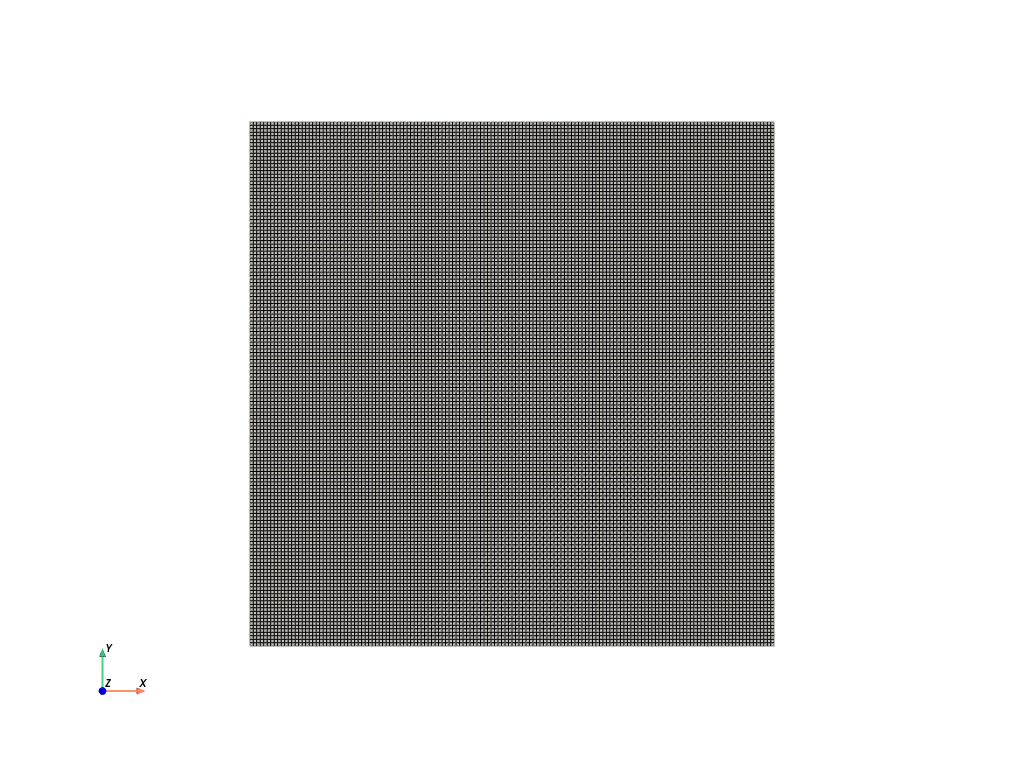

In [8]:
# create grid of coordinates
(easting, northing) = vd.grid_coordinates(
    region=buffer_region,
    spacing=spacing,
)

surface = vd.make_xarray_grid(
    (easting, northing),
    np.ones_like(easting) * prism_top,
    data_names="z",
    dims=("y", "x"),
).z

surface.pyvista.plot(
    x="x", y="y", show_edges=True, cpos="xy", jupyter_backend="static", color="white"
)

## Forward gravity

Number of prisms: 22801


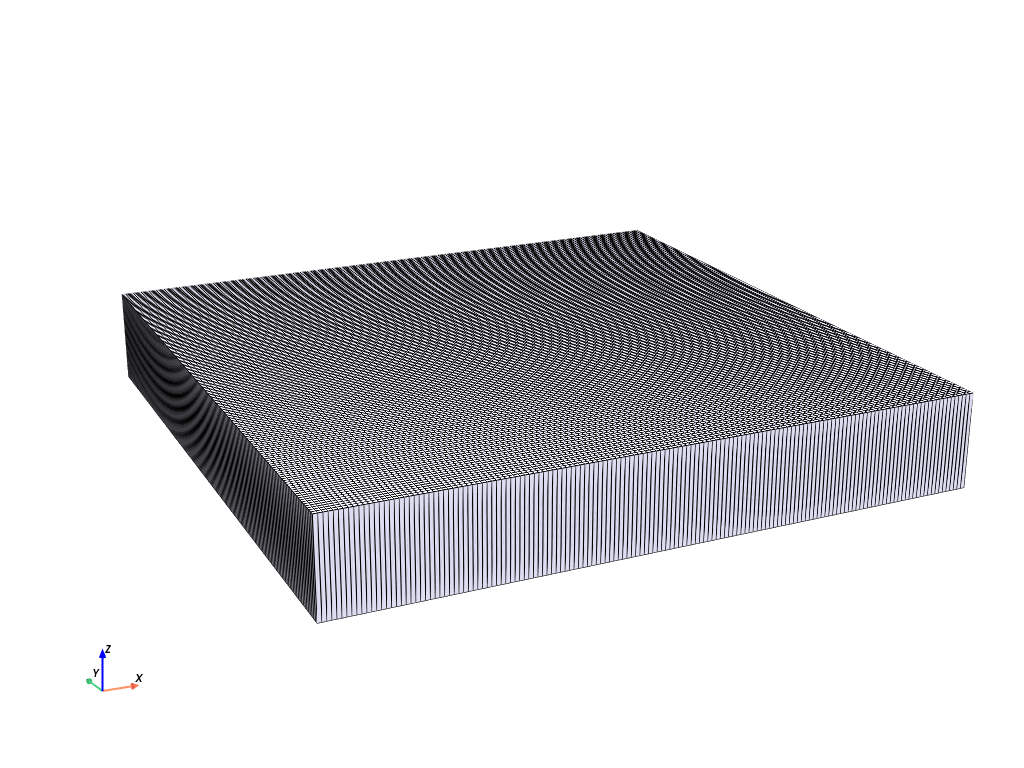

  0%|          | 0/2601 [00:00<?, ?it/s]

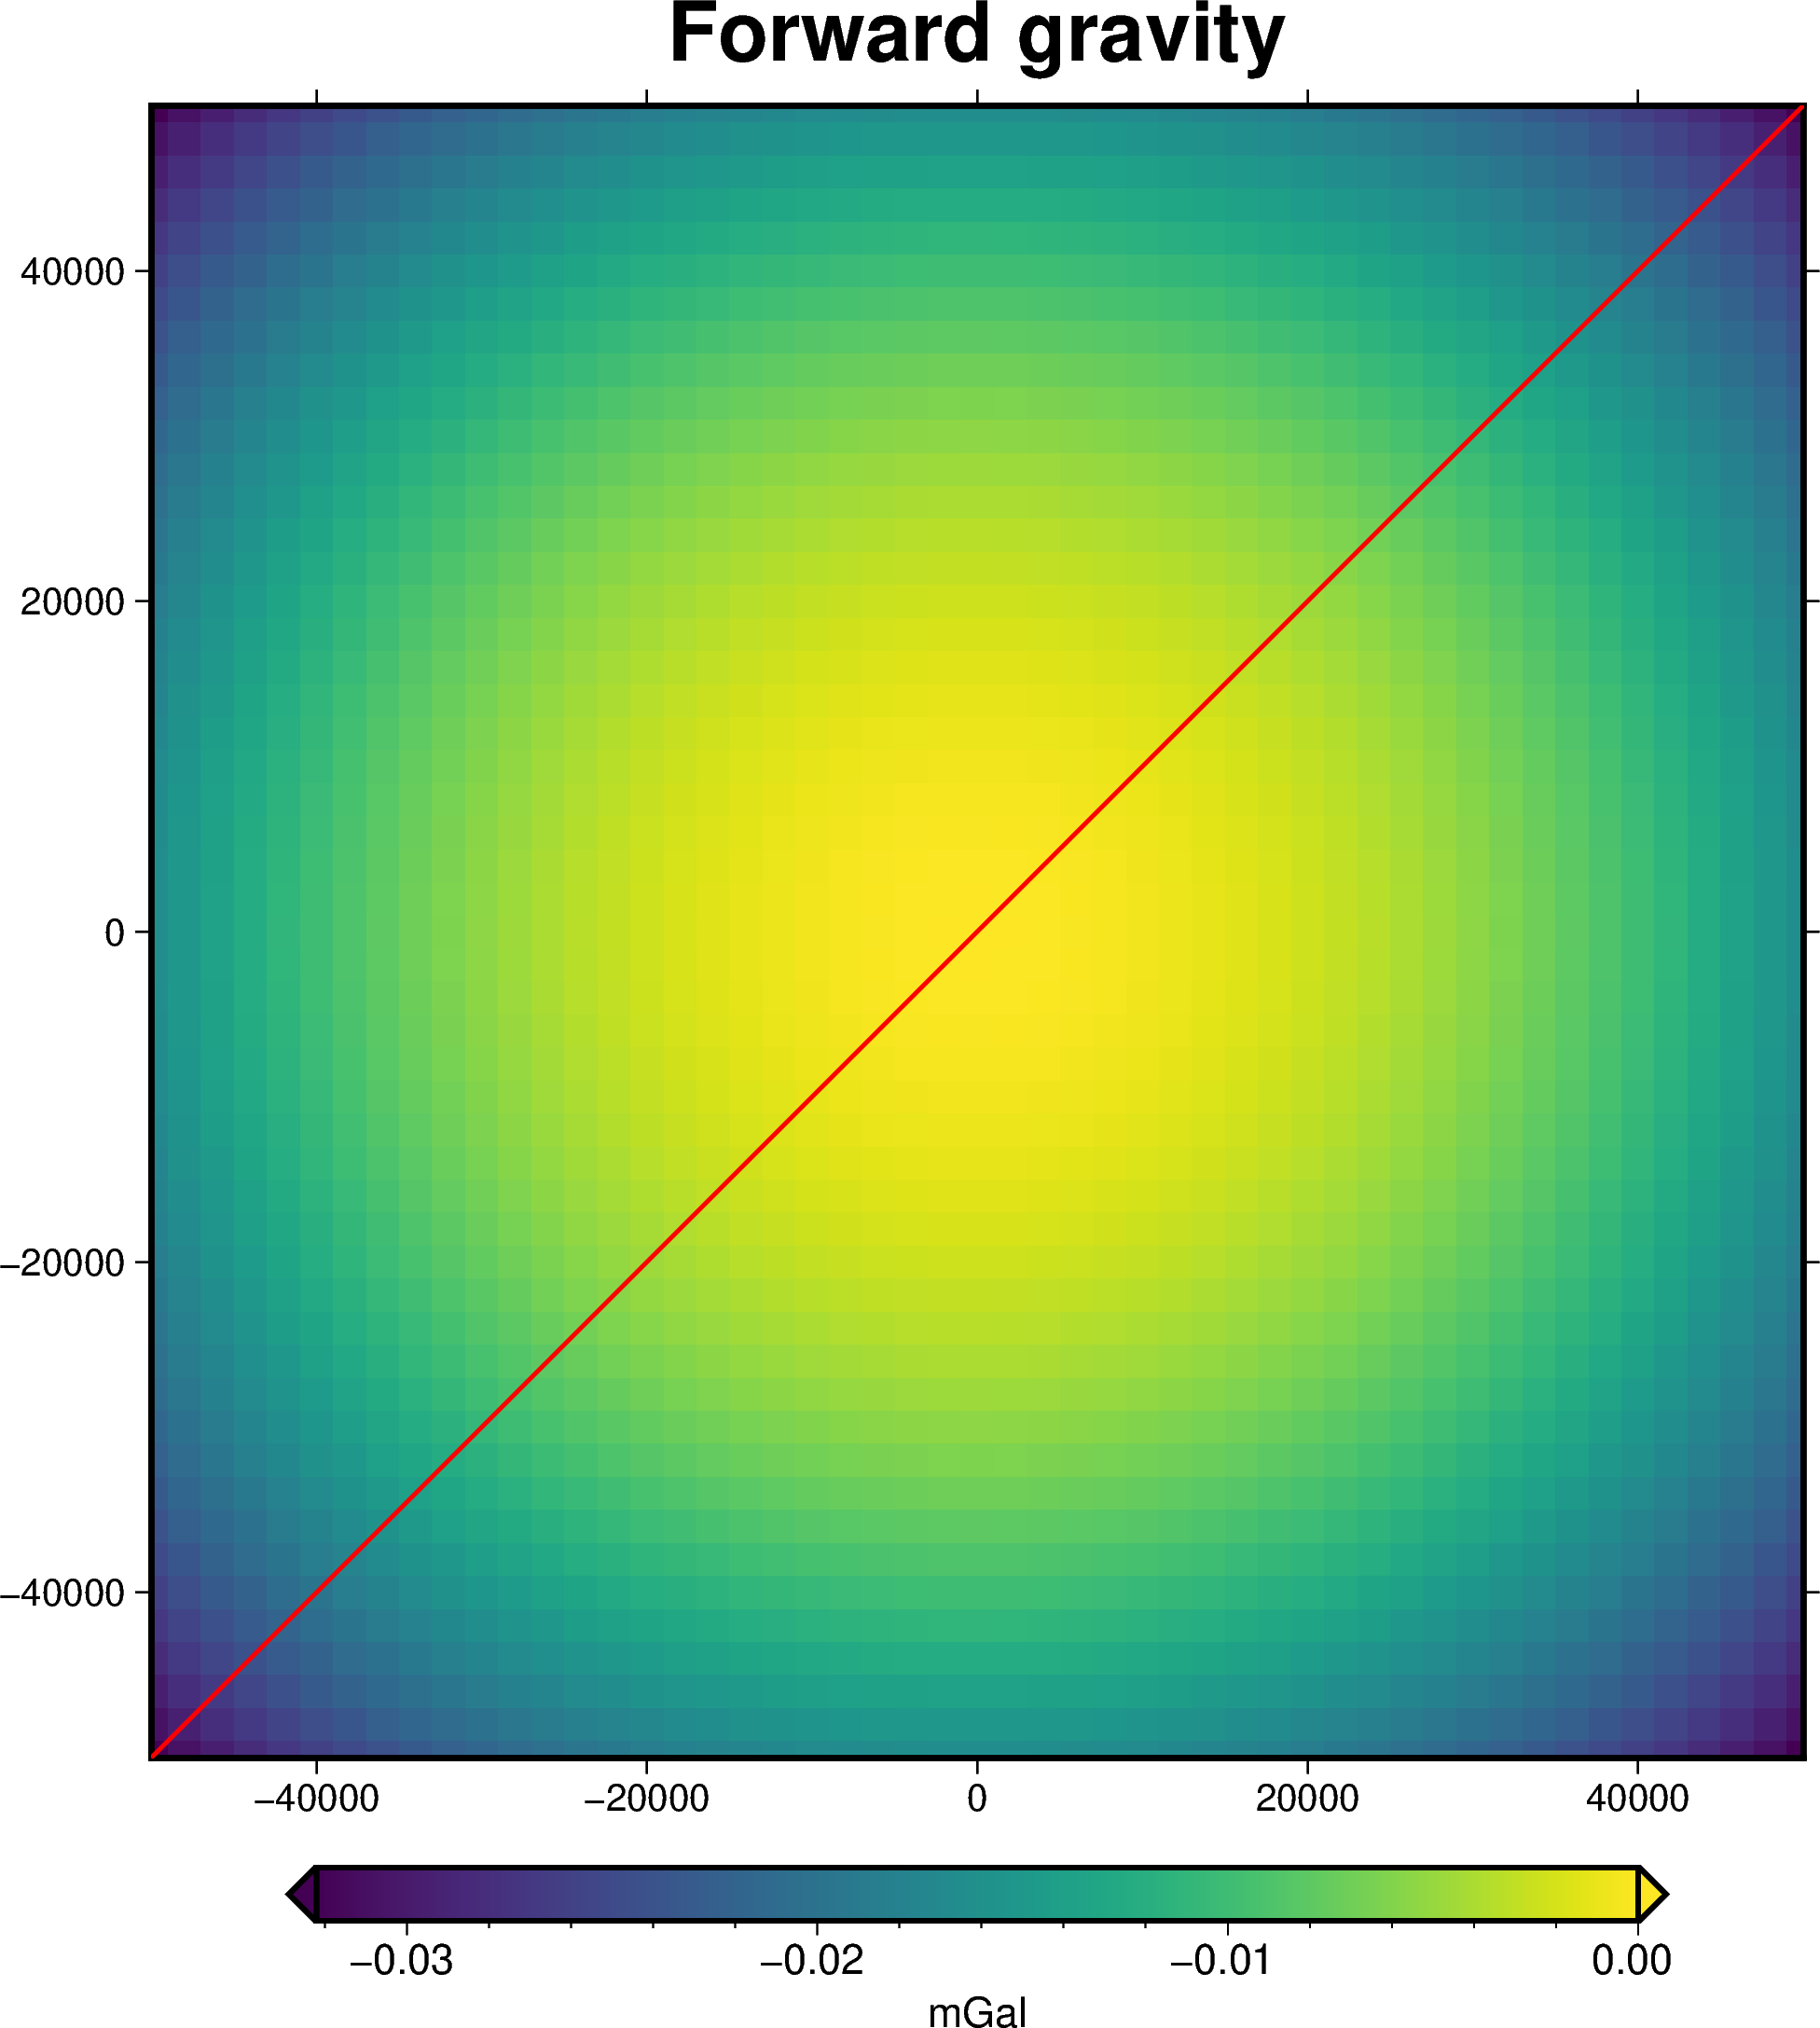

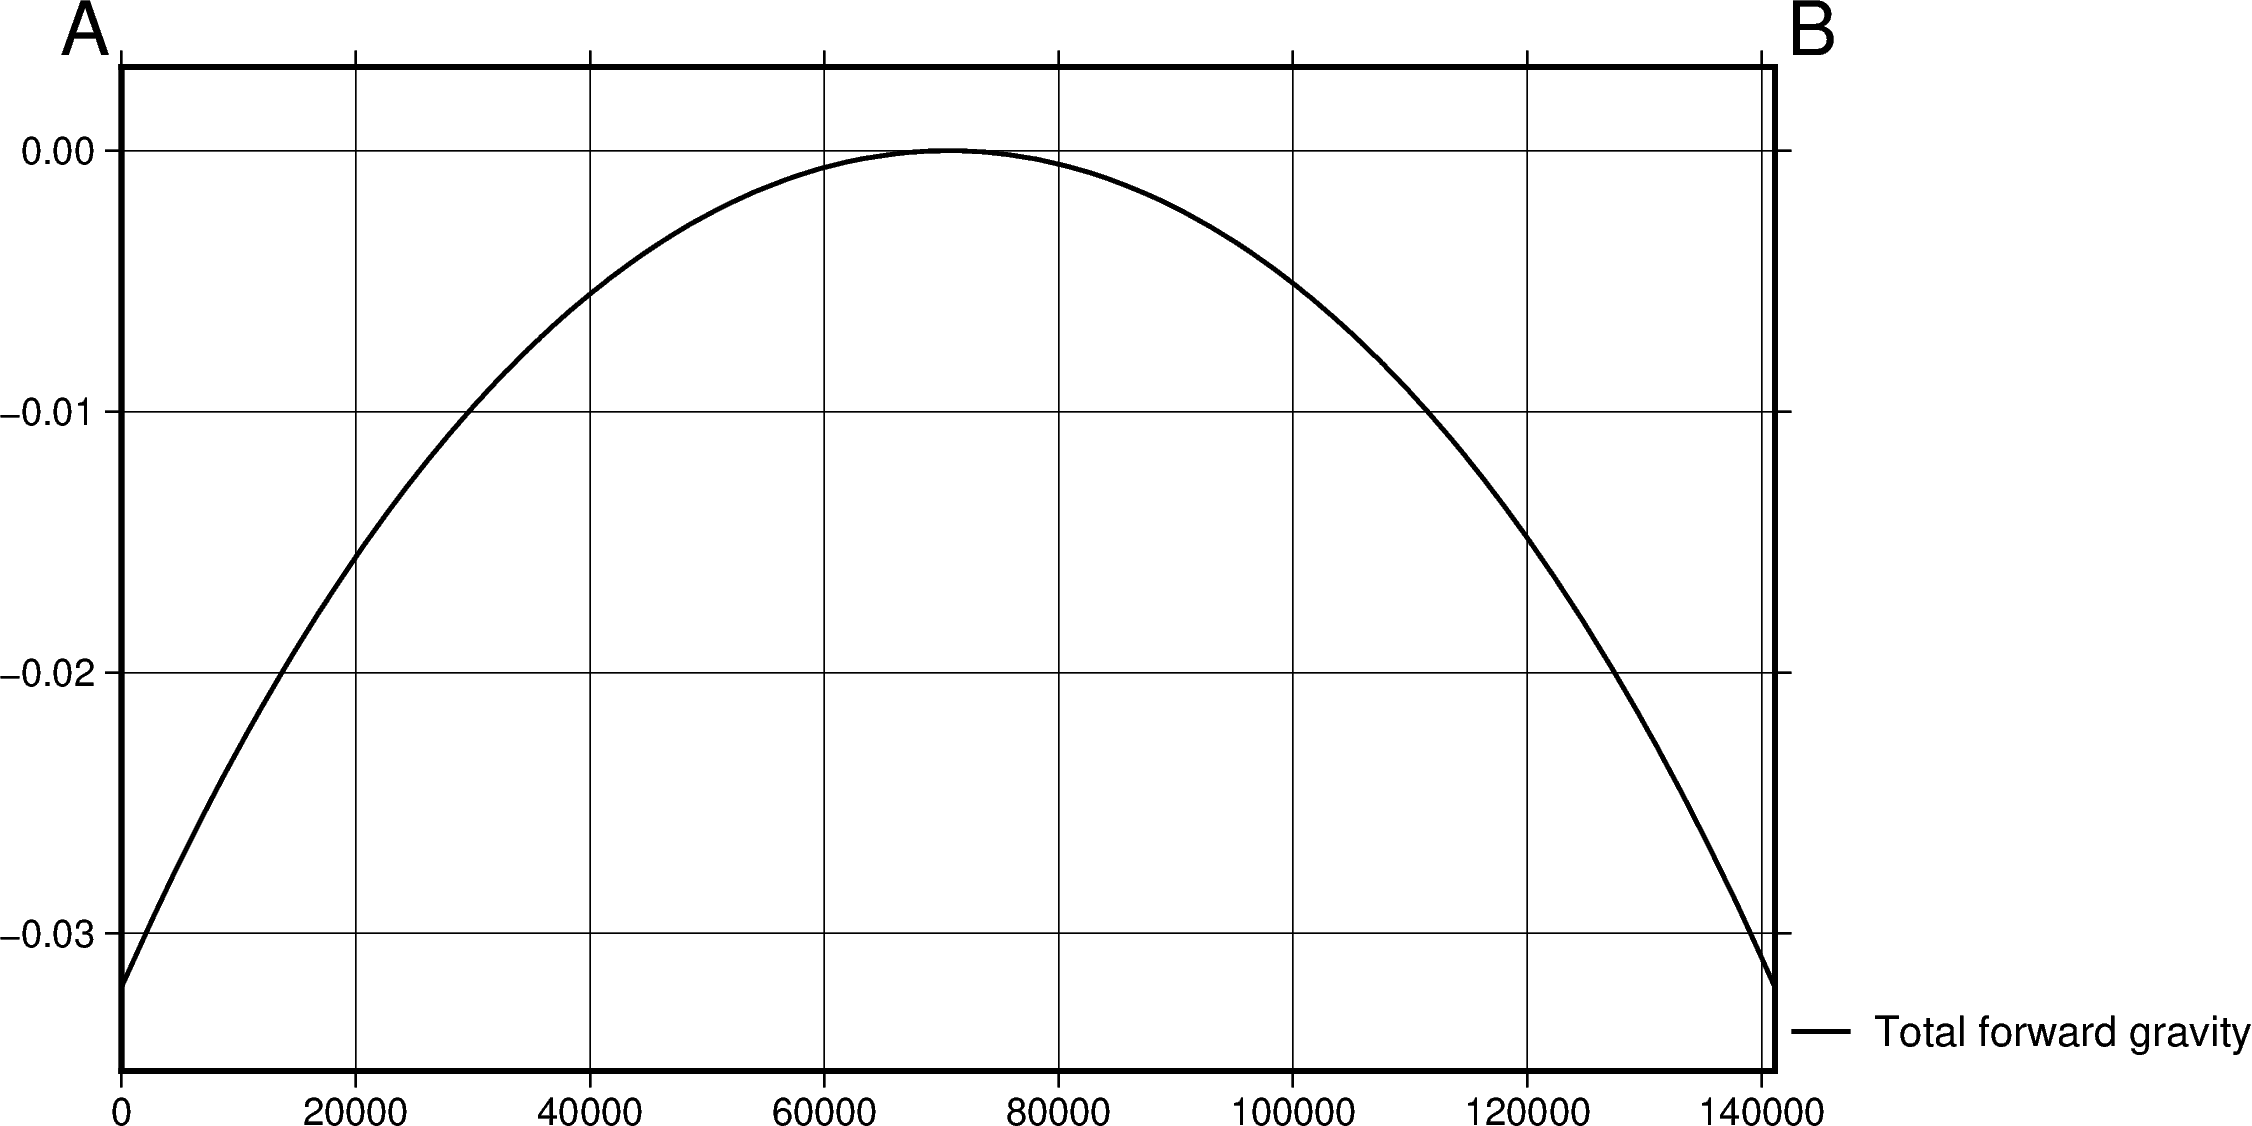

forward calculation took 2.253638744354248 secs


In [42]:
prisms = inv_utils.grids_to_prisms(
    surface,
    prism_base,
    density=density,
    input_coord_names=("x", "y"),
)

print(f"Number of prisms: {len(vd.grid_to_table(prisms))}")

plotting.show_prism_layers(
    [prisms],
    color_by="constant",
    clip_box=False,
    zscale=150,
    show_edges=True,
)

constant_forward_grav, constant_time = forward_grav_of_prismlayer(
    [prisms],
    observation_points,
    plot=True,
    names=["Forward gravity"],
)
print(f"forward calculation took {constant_time} secs")

## Forward gravity low-res

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


Number of prisms: 2601


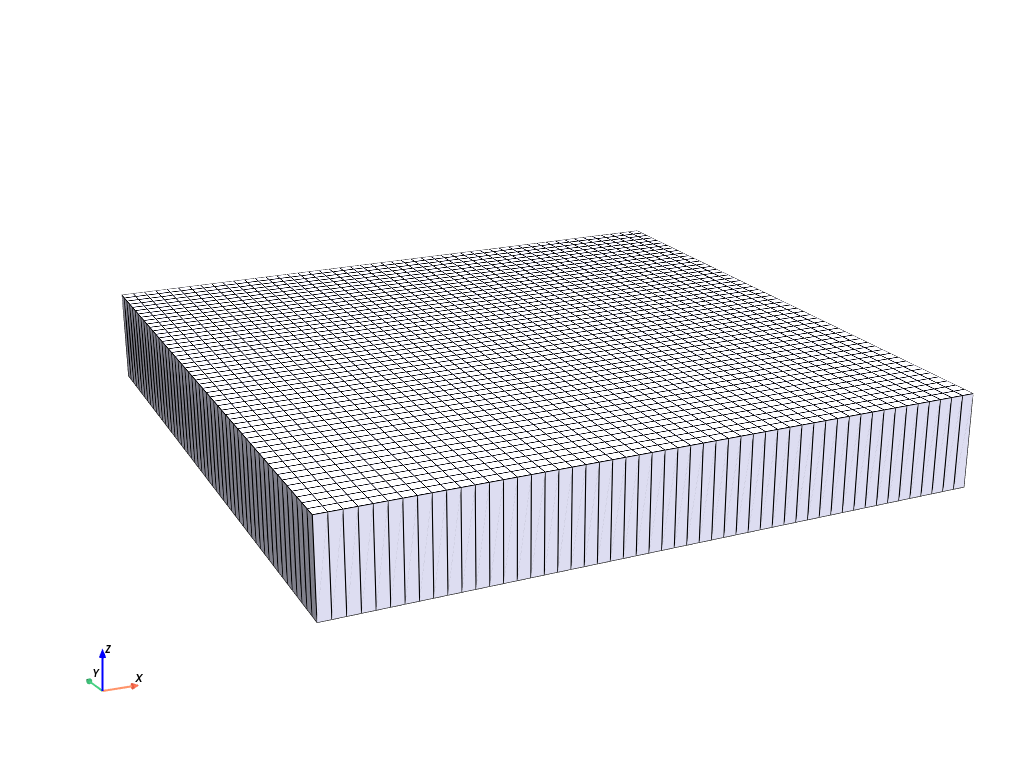

  0%|          | 0/2601 [00:00<?, ?it/s]

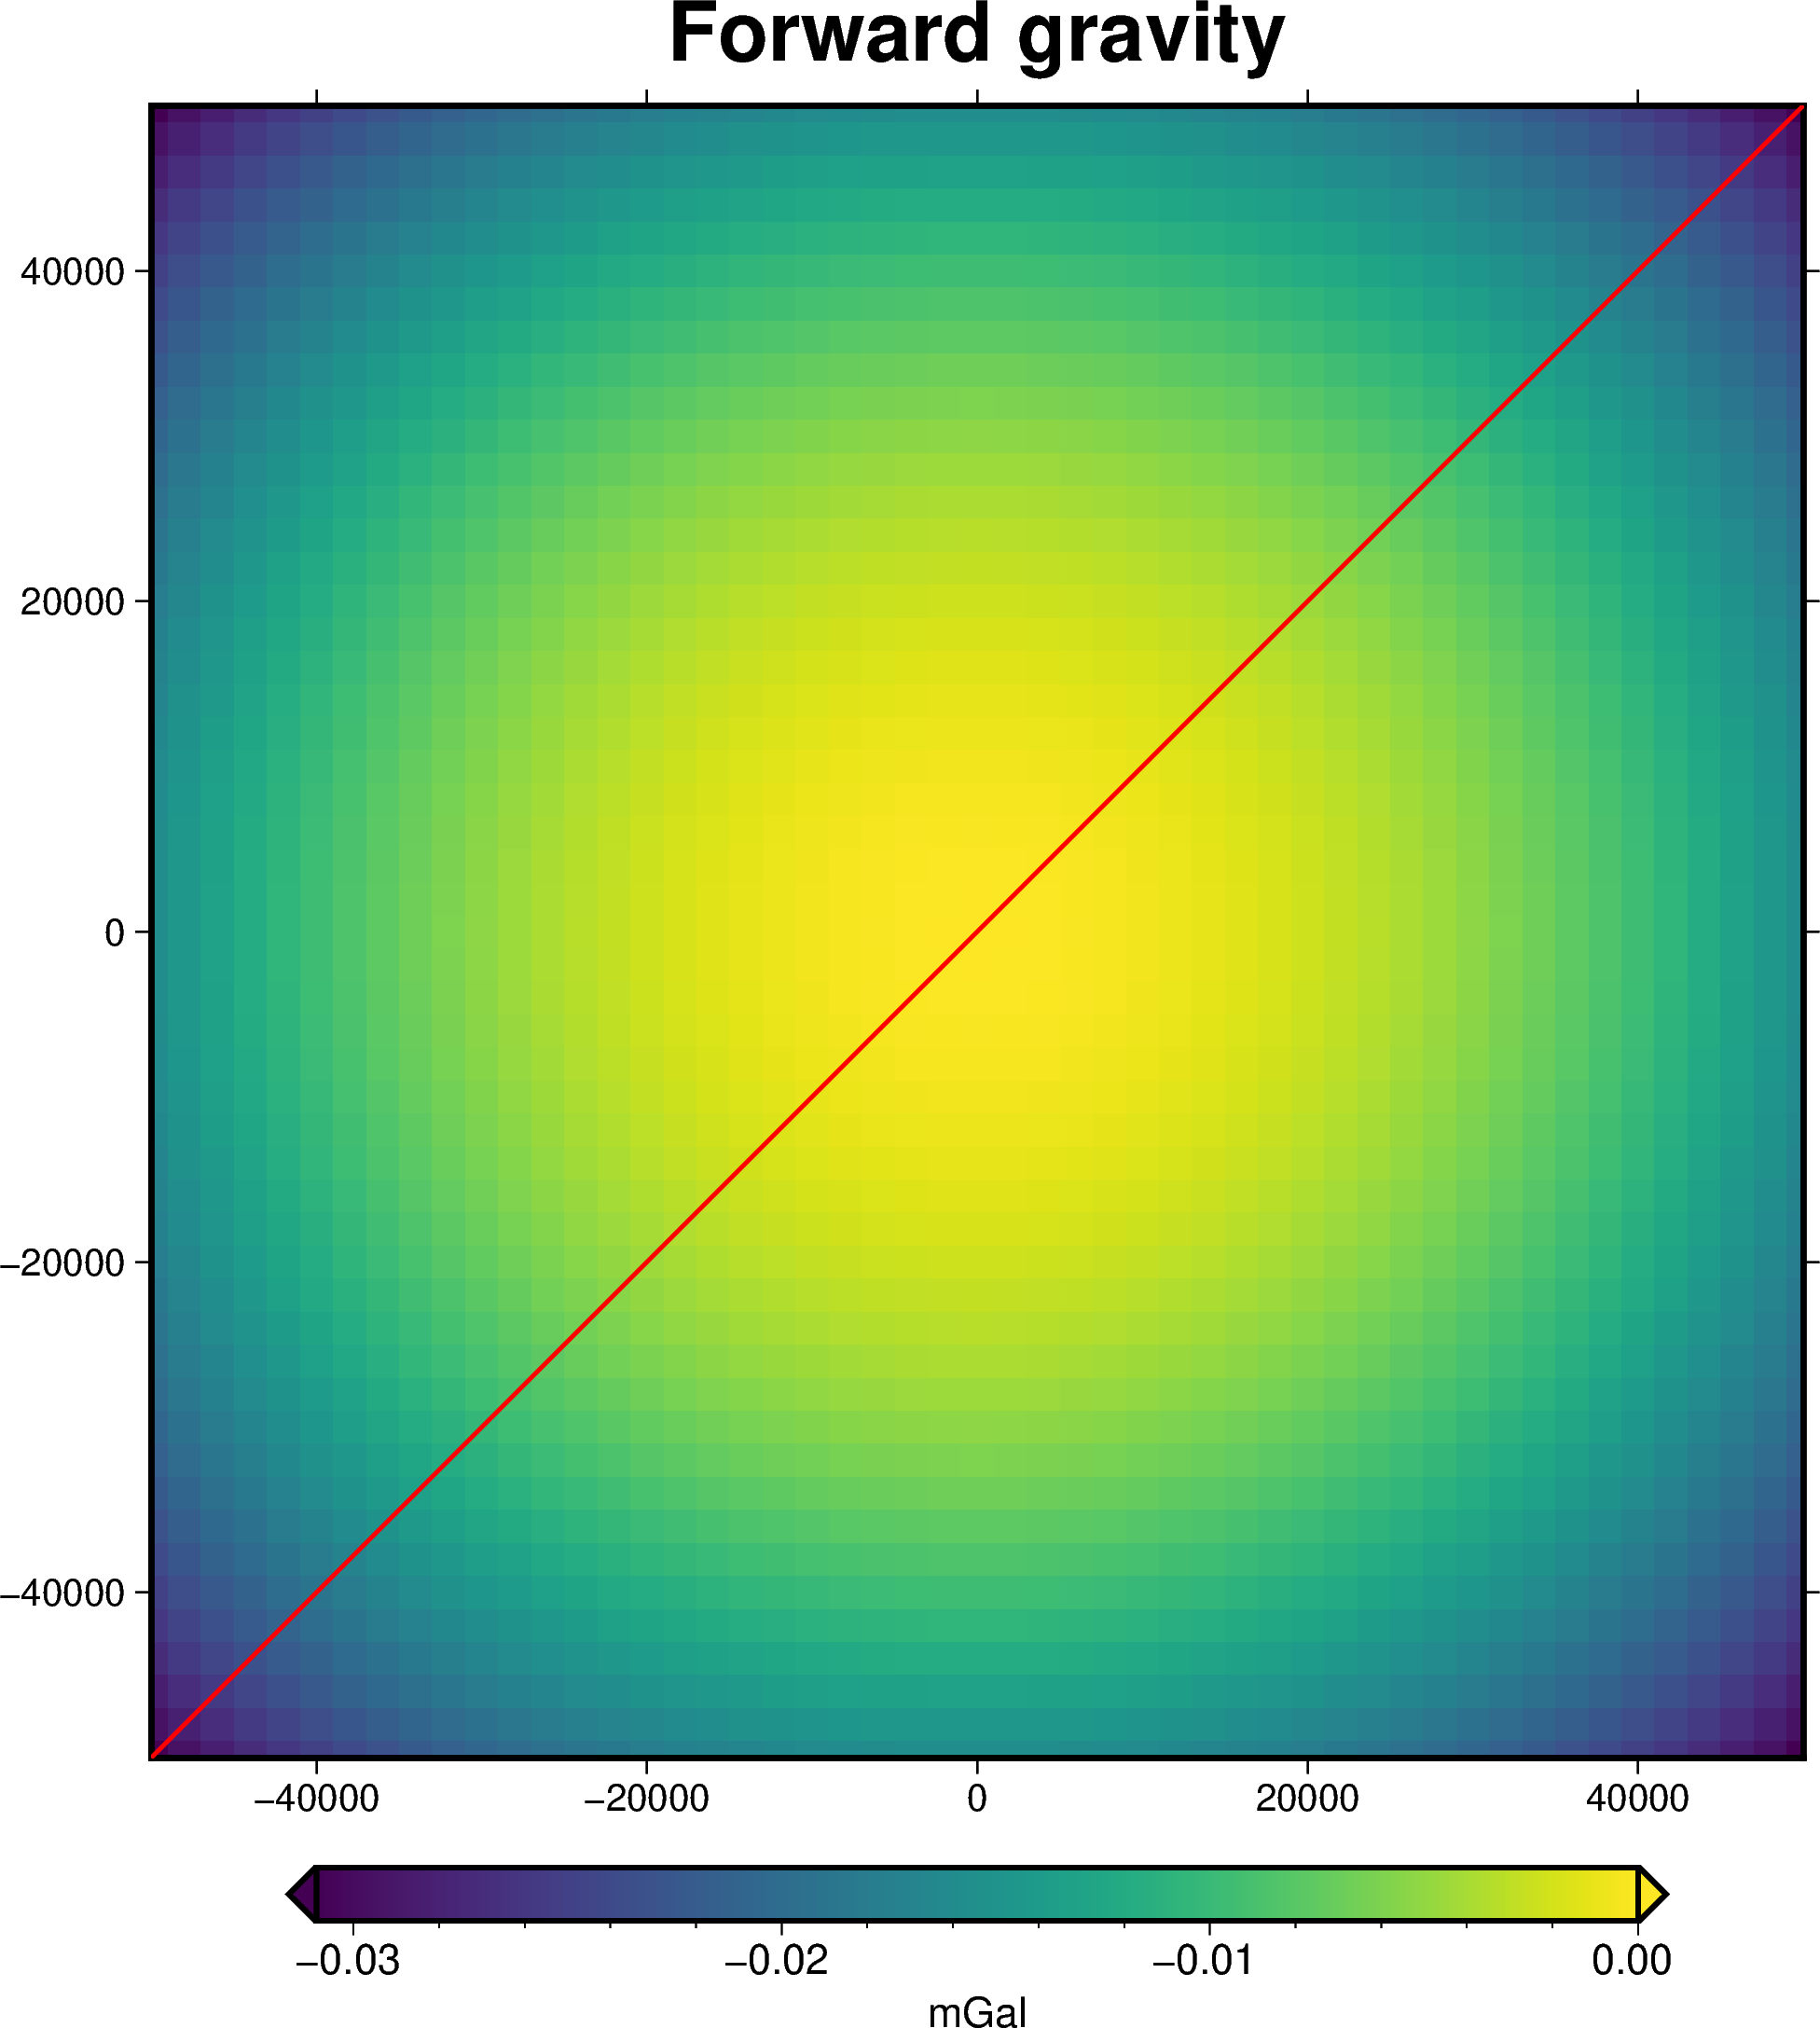

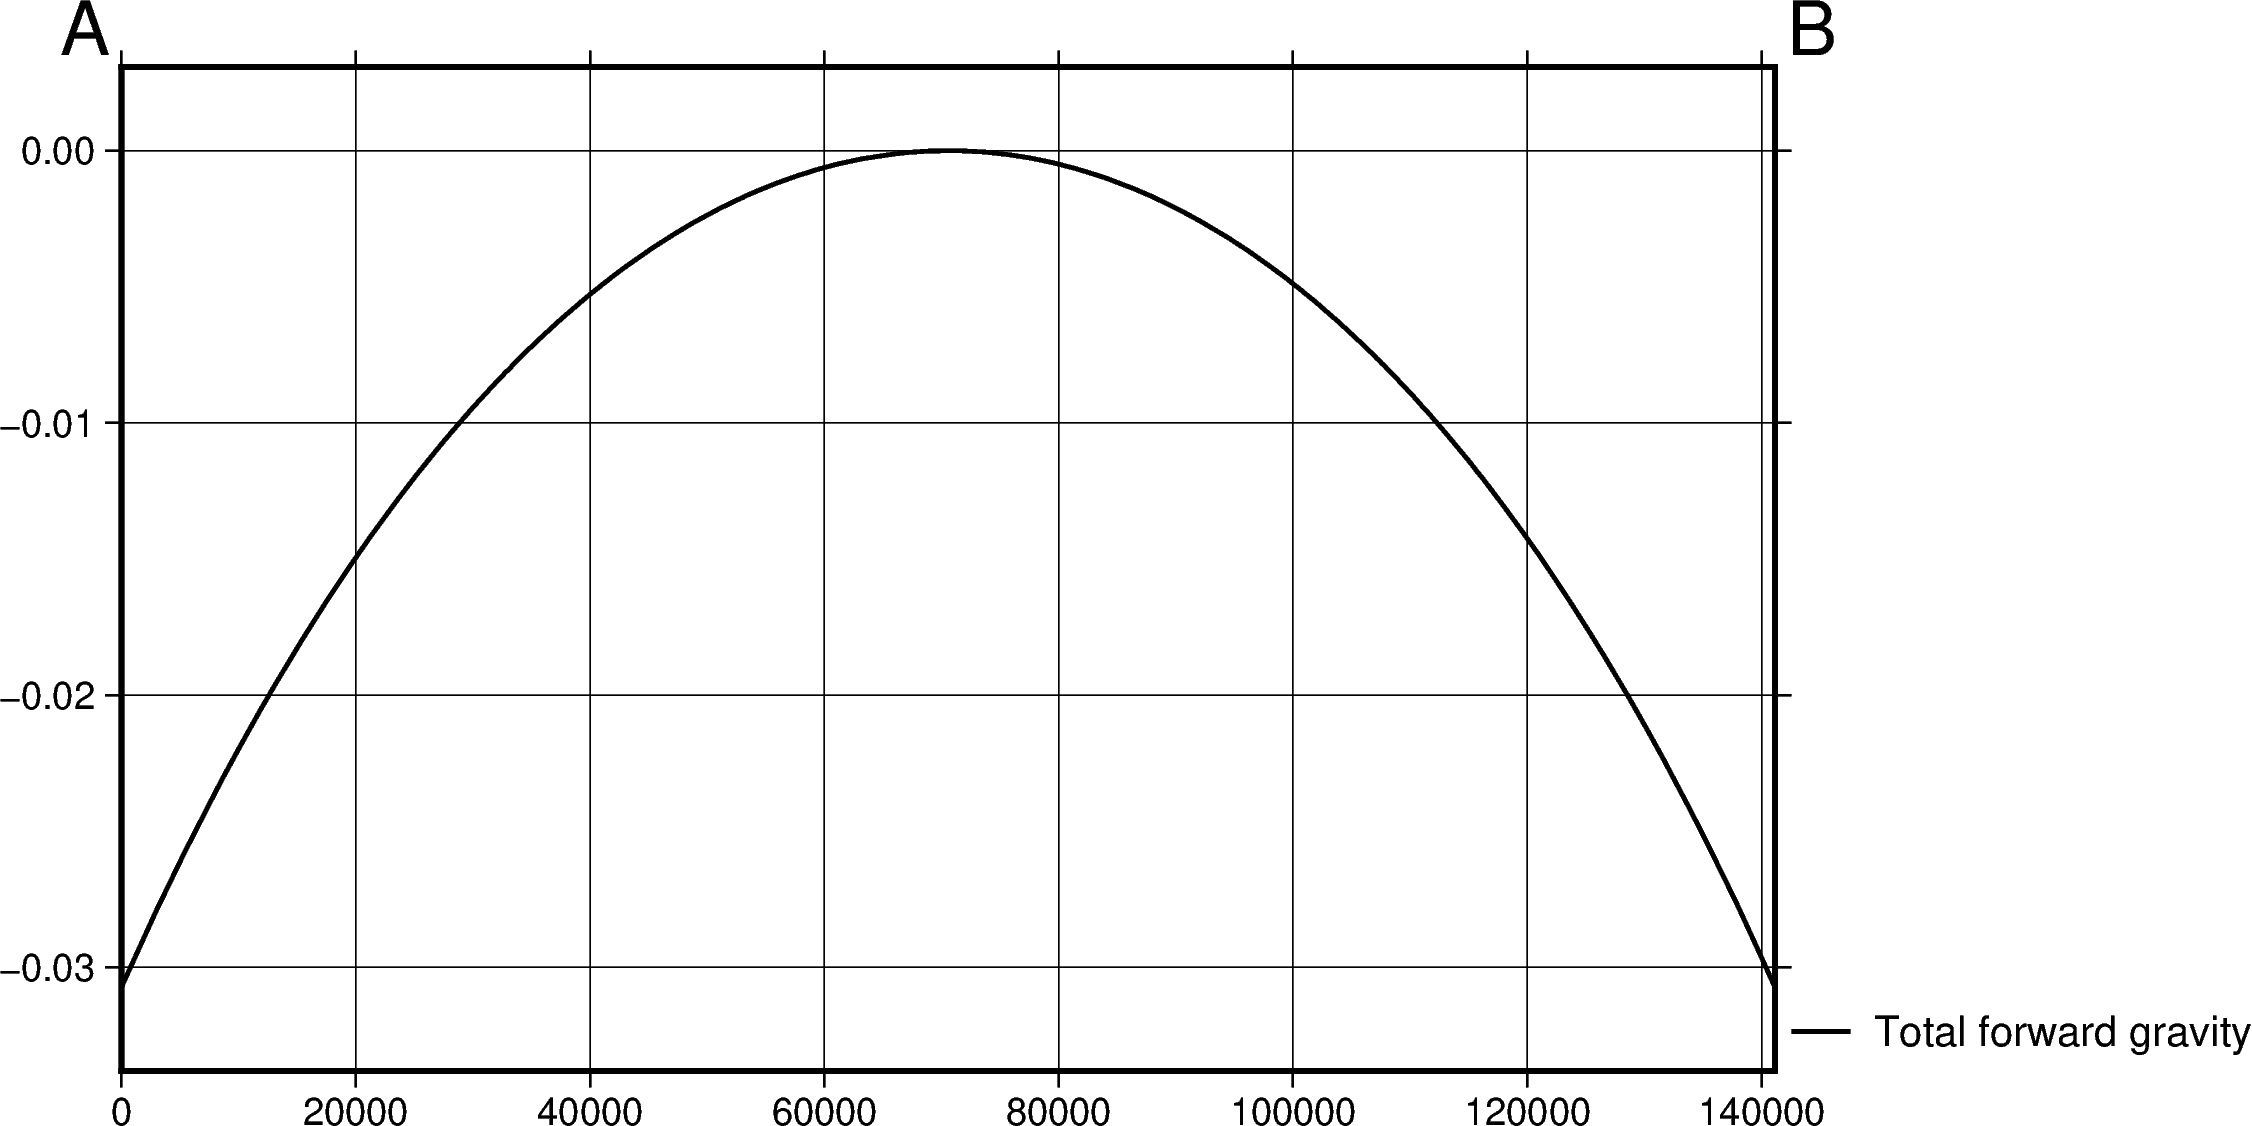

forward calculation took 0.3110537528991699 secs


In [43]:
surface_lowres = fetch.resample_grid(
    surface,
    region=buffer_region,
    spacing=spacing * 3,
)

prisms_lowres = inv_utils.grids_to_prisms(
    surface_lowres,
    prism_base,
    density=density,
    input_coord_names=("x", "y"),
)

print(f"Number of prisms: {len(vd.grid_to_table(prisms_lowres))}")

plotting.show_prism_layers(
    [prisms_lowres],
    color_by="constant",
    clip_box=False,
    zscale=150,
    show_edges=True,
)

constant_forward_grav_lowres, constant_time = forward_grav_of_prismlayer(
    [prisms_lowres],
    observation_points,
    plot=True,
    names=["Forward gravity"],
)
print(f"forward calculation took {constant_time} secs")

## Compare resolutions

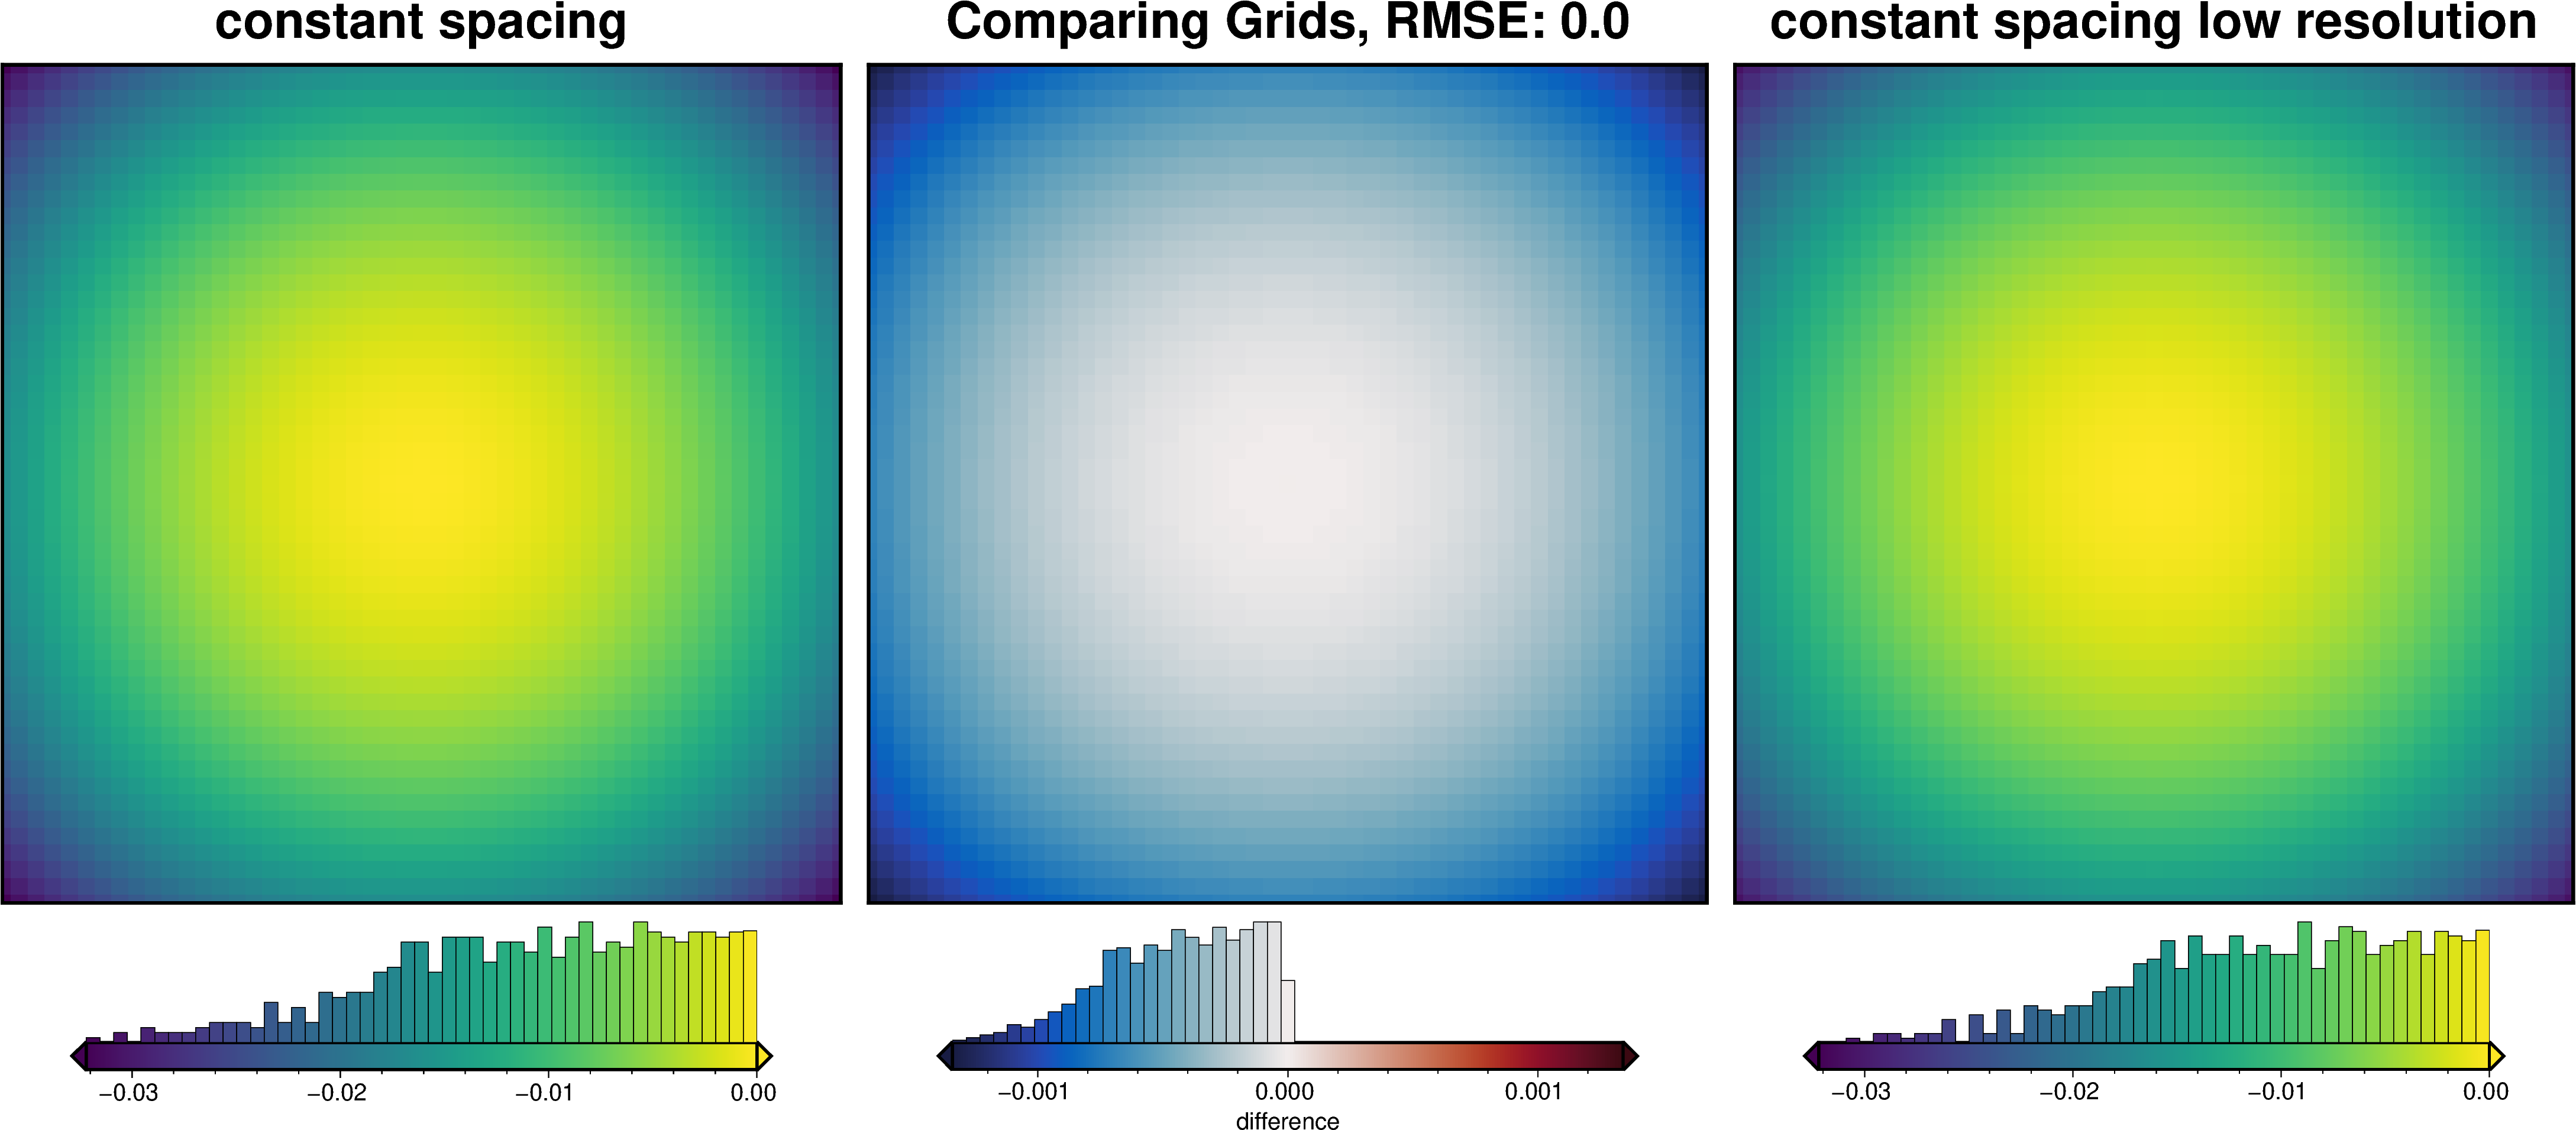

In [ ]:
grids = utils.grd_compare(
    constant_forward_grav[0],
    constant_forward_grav_lowres[0],
    plot=True,
    inset=False,
    grid1_name="constant spacing",
    grid2_name="constant spacing low resolution ",
    show_region=inner_region,
    # diff_cmap="hot",
    hist=True,
    hist_bin_num=50,
)

# 1 expanding buffer zone

## make surface grid (inner and buffer)

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


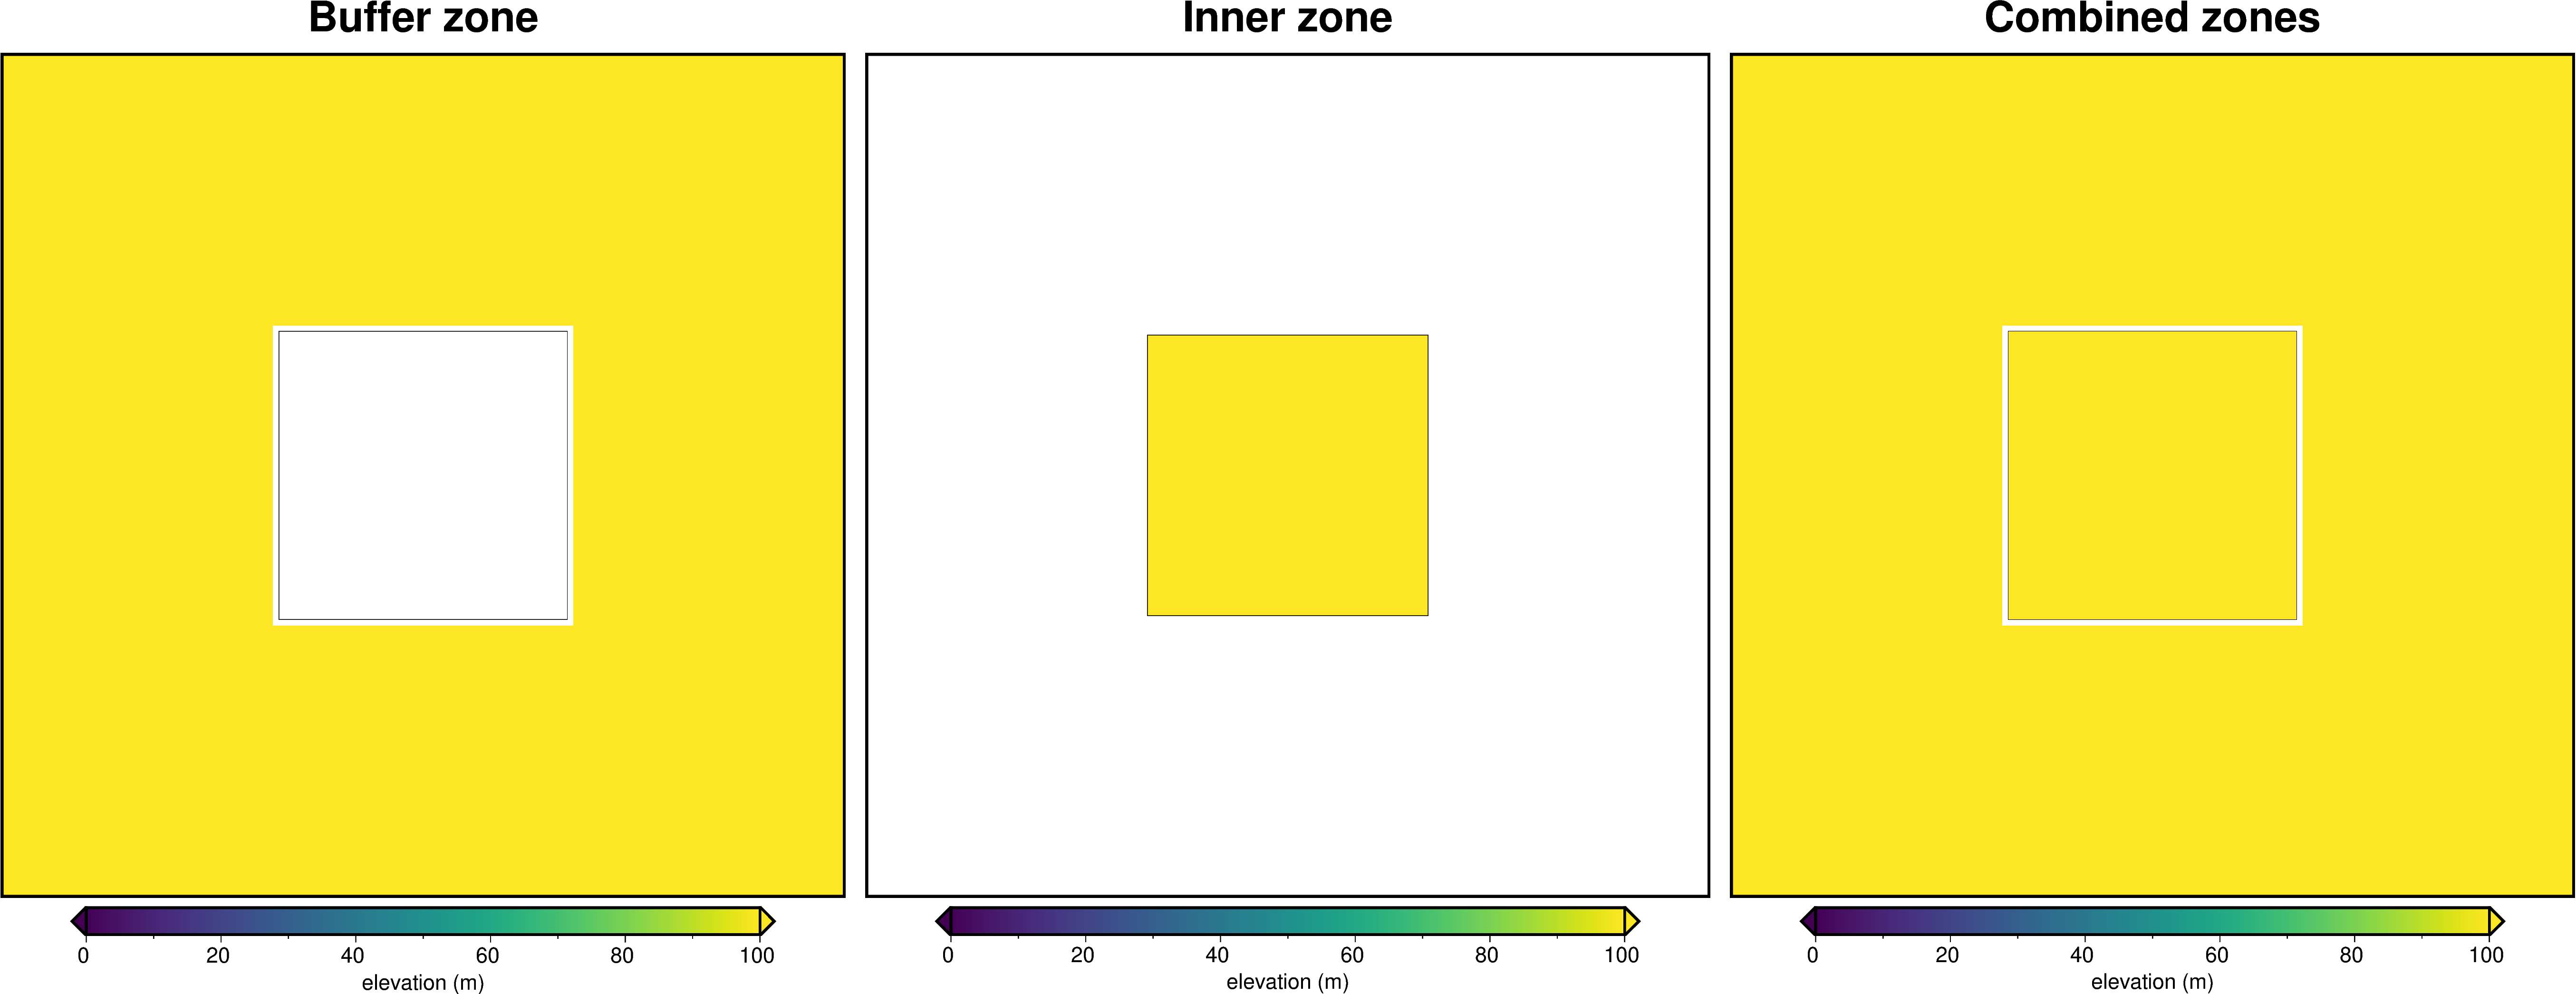

In [53]:
inner_surface = fetch.resample_grid(
    surface,
    region=inner_region,
    registration="p",
)

buffer_spacing = int(spacing * 2)

buffer_surface = fetch.resample_grid(surface, spacing=buffer_spacing, registration="p")

buffer_surface = buffer_surface.where(
    (buffer_surface.x < inner_region[0])
    | (buffer_surface.x > inner_region[1])
    | (buffer_surface.y < inner_region[2])
    | (buffer_surface.y > inner_region[3])
)

# plot buffer zone
fig = maps.plot_grd(
    buffer_surface,
    cpt_lims=[0, 100],
    title="Buffer zone",
    cbar_label="elevation (m)",
    show_region=inner_region,
)

# plot inner zone
fig = maps.plot_grd(
    inner_surface,
    region=buffer_region,
    cpt_lims=[0, 100],
    title="Inner zone",
    cbar_label="elevation (m)",
    show_region=inner_region,
    fig=fig,
    origin_shift="xshift",
)

# plot both inner and buffer
fig = maps.plot_grd(
    buffer_surface,
    cpt_lims=[0, 100],
    title="Combined zones",
    cbar_label="elevation (m)",
    show_region=inner_region,
    fig=fig,
    origin_shift="xshift",
)
fig.grdimage(inner_surface, cmap=True, transparency=0)

fig.show()

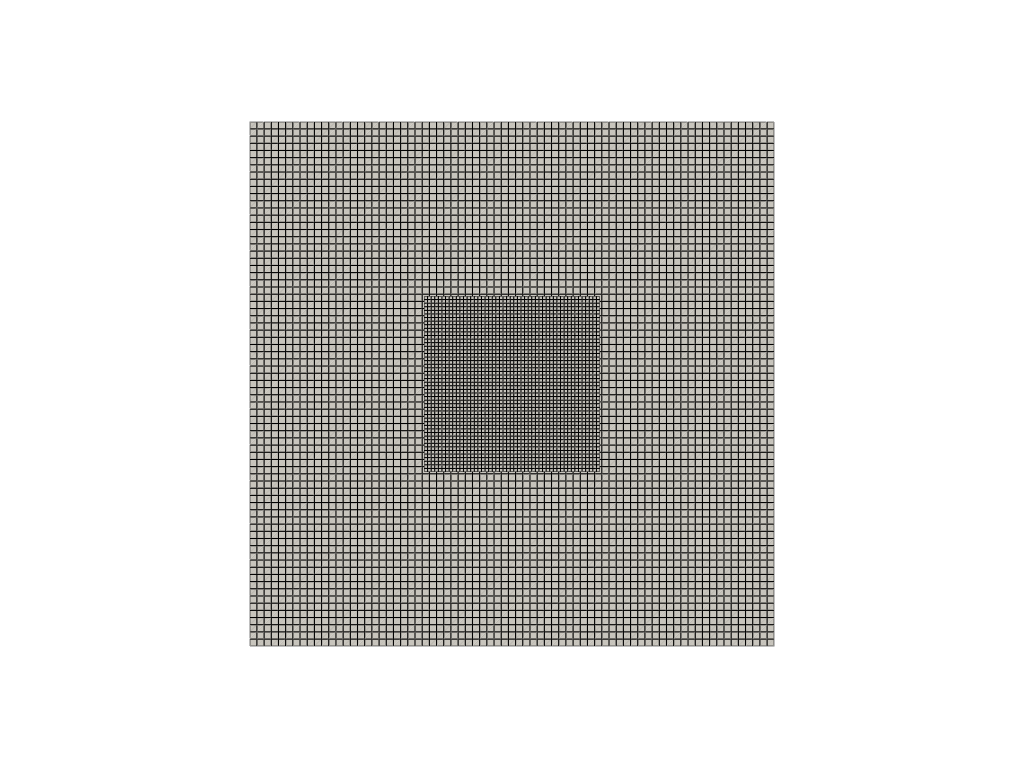

In [54]:
p = pv.Plotter()

p.add_mesh(buffer_surface.pyvista.mesh(x="x", y="y"), show_edges=True, color="white")
p.add_mesh(inner_surface.pyvista.mesh(x="x", y="y"), show_edges=True, color="white")
p.show(cpos="xy", jupyter_backend="static")

## make prism layer

Number of prisms: 7976


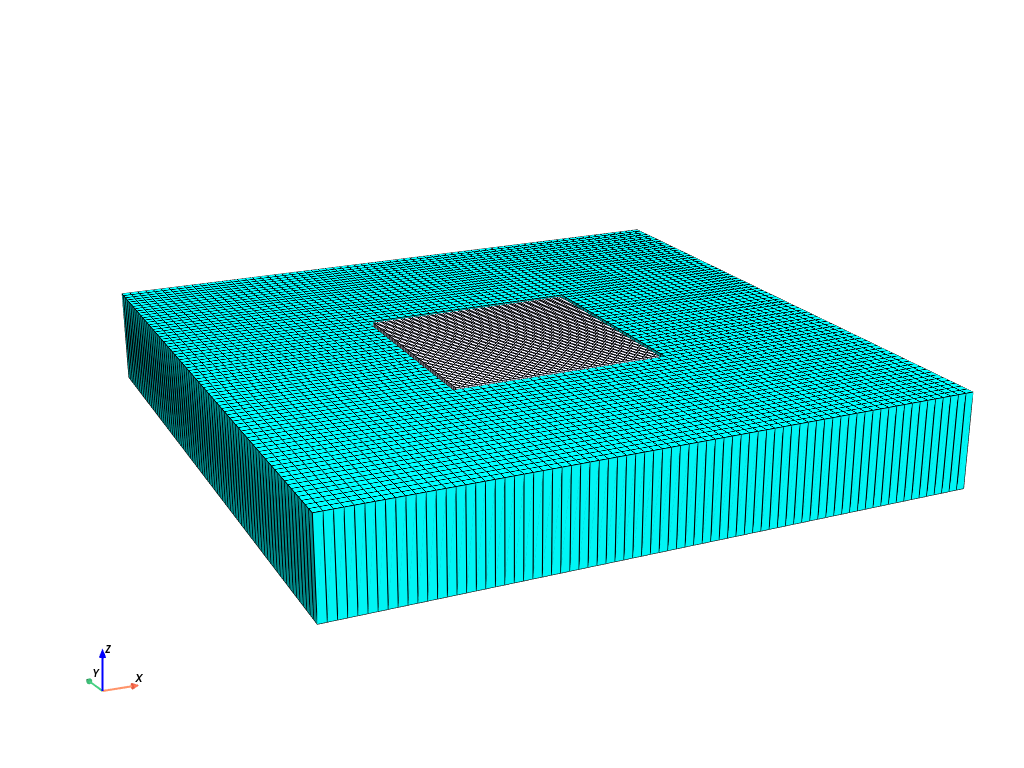

In [55]:
inner_prisms = inv_utils.grids_to_prisms(
    inner_surface,
    prism_base,
    density=density,
    input_coord_names=("x", "y"),
)

buffer_prisms = inv_utils.grids_to_prisms(
    buffer_surface,
    prism_base,
    density=density,
    input_coord_names=("x", "y"),
)

num = len(vd.grid_to_table(inner_prisms)) + len(vd.grid_to_table(buffer_prisms))

print(f"Number of prisms: {num}")

plotting.show_prism_layers(
    [inner_prisms, buffer_prisms],
    color_by="constant",
    clip_box=False,
    zscale=150,
    show_edges=True,
)

## calculate forward gravity

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

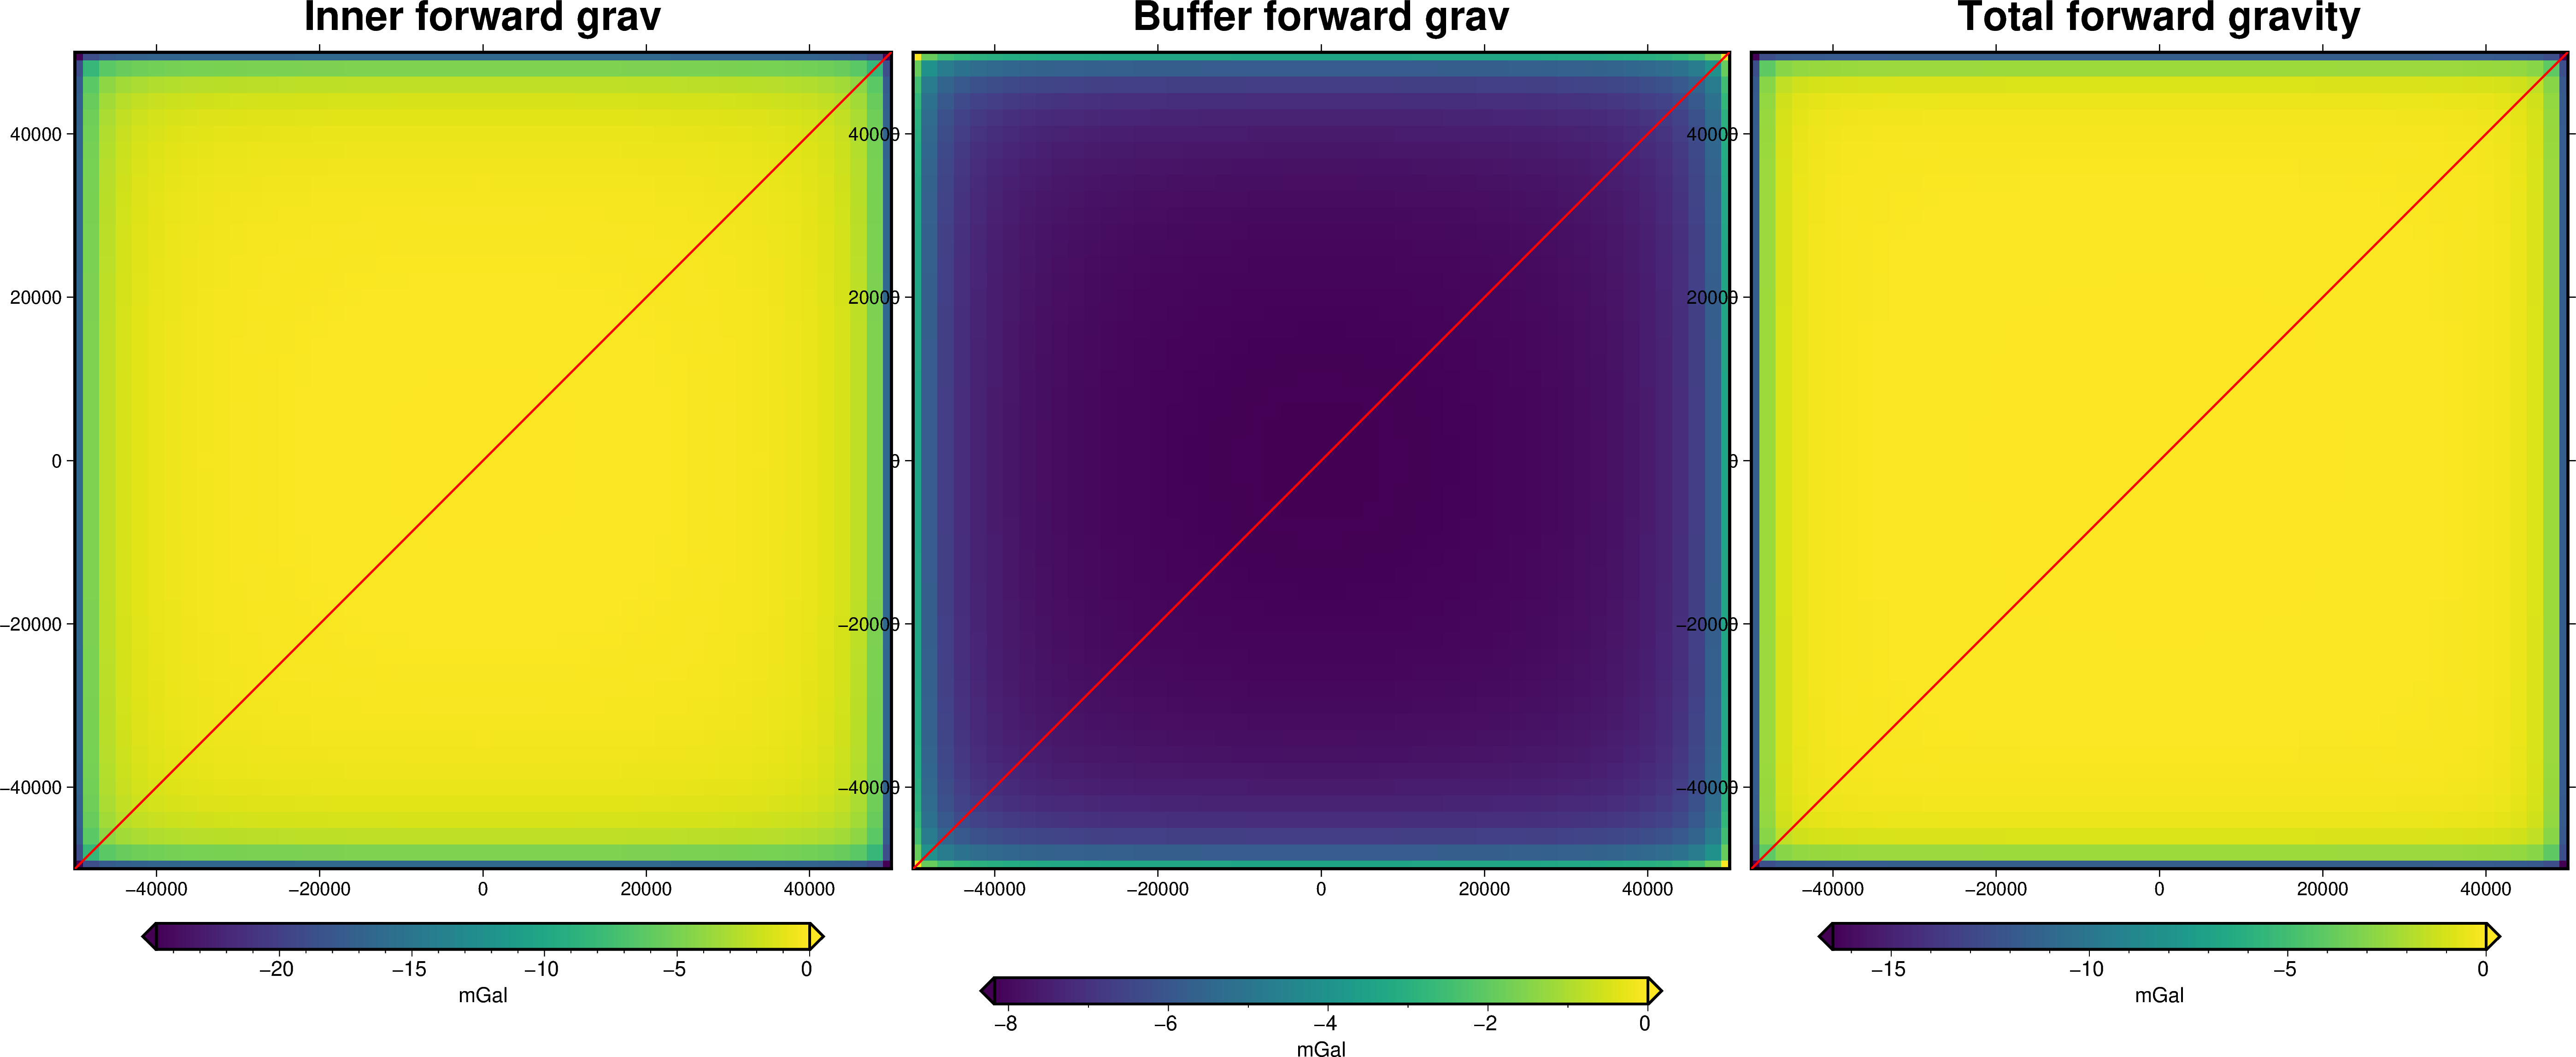

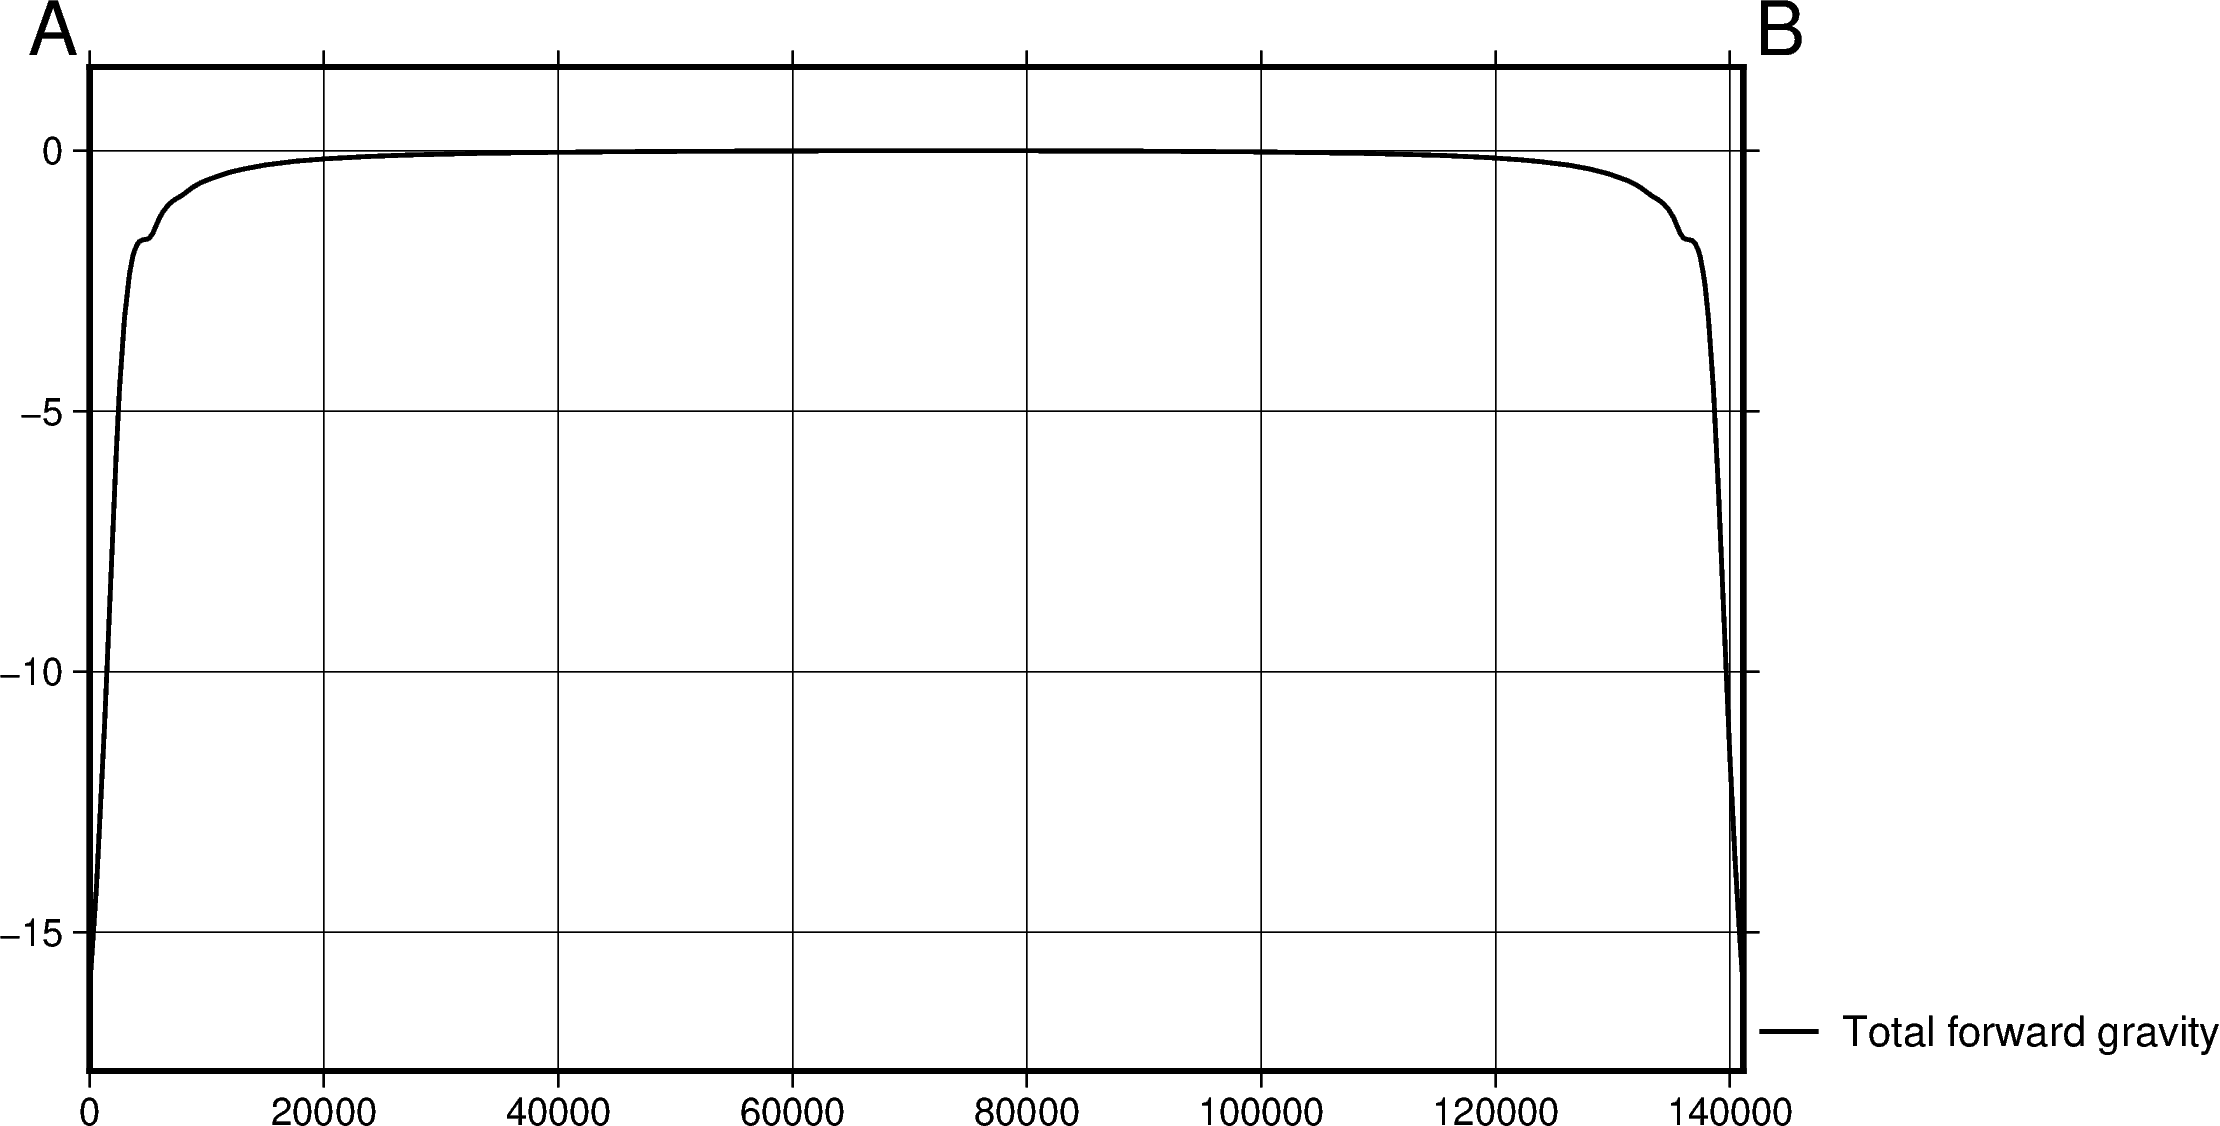

forward calculation took 0.7862439155578613 secs


In [56]:
single_buffer_forward_grav, single_buffer_time = forward_grav_of_prismlayer(
    [inner_prisms, buffer_prisms],
    observation_points,
    plot=True,
    names=["Inner forward grav", "Buffer forward grav"],
)
print(f"forward calculation took {single_buffer_time} secs")

# 2 expanding buffer zones

## define regions

In [27]:
buffer1_region = utils.alter_region(inner_region, zoom=-buffer_zoom / 2)
buffer2_region = utils.alter_region(buffer1_region, zoom=-buffer_zoom / 2)

print(inner_region)
print(buffer1_region)
print(buffer2_region)

[-50000.0, 50000.0, -50000.0, 50000.0]
(-100000.0, 100000.0, -100000.0, 100000.0)
(-150000.0, 150000.0, -150000.0, 150000.0)


## make surface grids

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


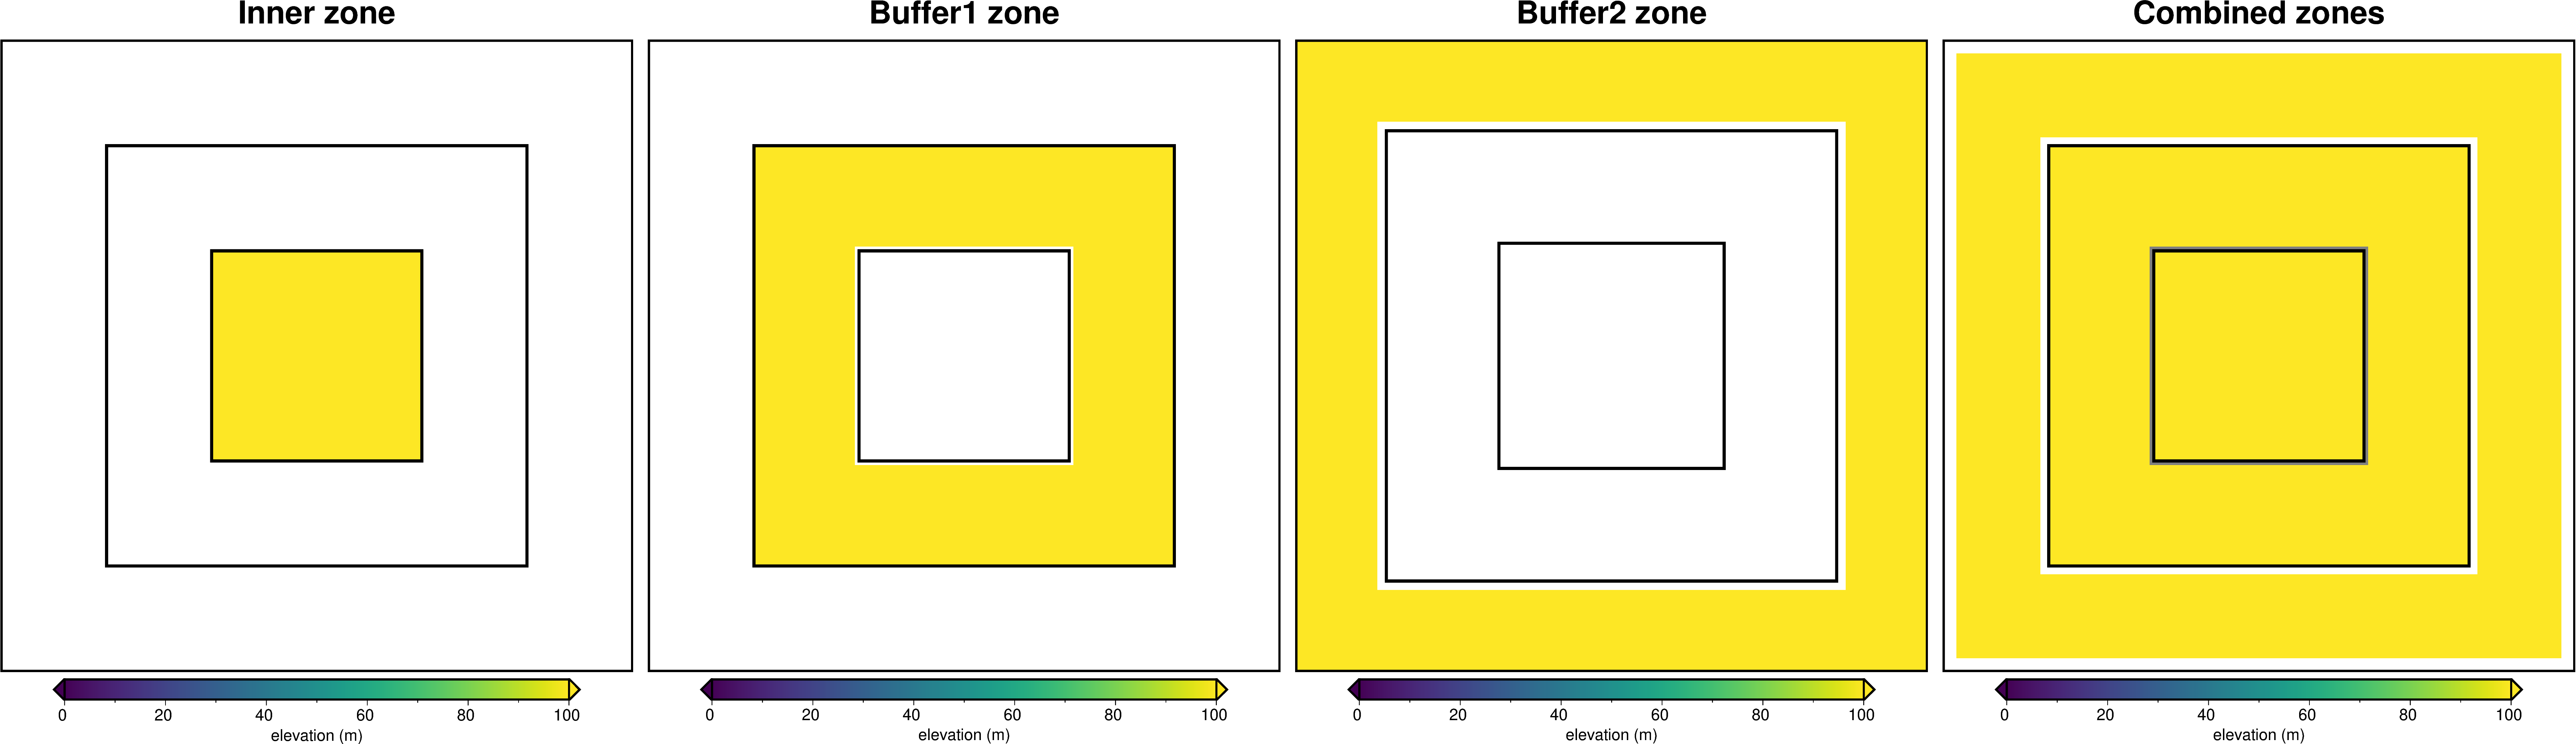

In [28]:
buffer1_spacing = spacing * 2
buffer2_spacing = buffer1_spacing * 2

buffer1_surface = fetch.resample_grid(
    surface, spacing=buffer1_spacing, registration="p"
)

buffer2_surface = fetch.resample_grid(
    surface, spacing=buffer2_spacing, registration="p"
)

# mask outside buffer1
buffer1_surface = fetch.resample_grid(buffer1_surface, region=buffer1_region)

# mask inner region
buffer1_surface = buffer1_surface.where(
    (buffer1_surface.x < inner_region[0])
    | (buffer1_surface.x > inner_region[1])
    | (buffer1_surface.y < inner_region[2])
    | (buffer1_surface.y > inner_region[3])
)

# mask inside buffer1 region
buffer2_surface = buffer2_surface.where(
    (buffer2_surface.x < buffer1_region[0])
    | (buffer2_surface.x > buffer1_region[1])
    | (buffer2_surface.y < buffer1_region[2])
    | (buffer2_surface.y > buffer1_region[3])
)

# plot inner zone zone
fig = maps.plot_grd(
    inner_surface,
    region=buffer_region,
    cpt_lims=[0, 100],
    title="Inner zone",
    cbar_label="elevation (m)",
)
maps.add_box(fig, inner_region)
maps.add_box(fig, buffer1_region)

# plot buffer1 zone
fig = maps.plot_grd(
    buffer1_surface,
    region=buffer_region,
    cpt_lims=[0, 100],
    title="Buffer1 zone",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
)
maps.add_box(fig, inner_region)
maps.add_box(fig, buffer1_region)

# plot both inner and buffer
fig = maps.plot_grd(
    buffer2_surface,
    cpt_lims=[0, 100],
    title="Buffer2 zone",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
)
maps.add_box(fig, inner_region)
maps.add_box(fig, buffer1_region)

# plot 3 regions
fig = maps.plot_grd(
    buffer2_surface,
    region=buffer_region,
    cpt_lims=[0, 100],
    title="Combined zones",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
)
fig.grdimage(buffer1_surface, cmap=True, transparency=0)
fig.grdimage(inner_surface, cmap=True, transparency=0)
maps.add_box(fig, inner_region)
maps.add_box(fig, buffer1_region)

fig.show()

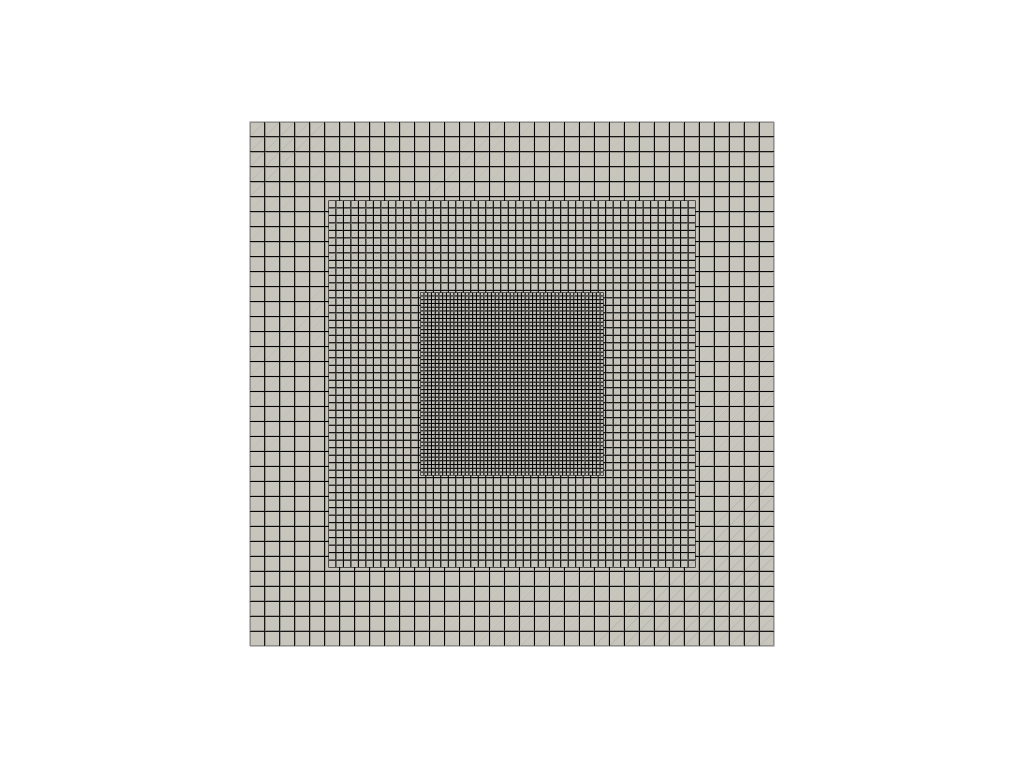

In [57]:
p = pv.Plotter()

p.add_mesh(buffer2_surface.pyvista.mesh(x="x", y="y"), show_edges=True, color="white")
p.add_mesh(buffer1_surface.pyvista.mesh(x="x", y="y"), show_edges=True, color="white")
p.add_mesh(inner_surface.pyvista.mesh(x="x", y="y"), show_edges=True, color="white")

p.show(cpos="xy", jupyter_backend="static")

## make prism layer

Number of prisms: 6296


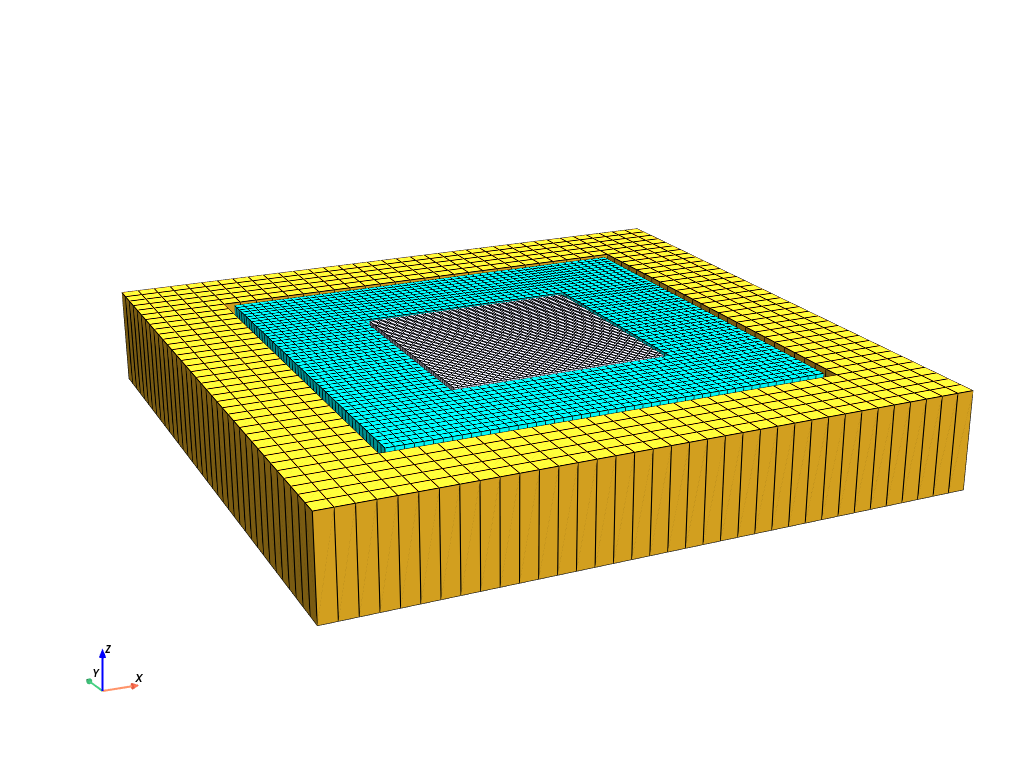

In [58]:
inner_prisms = inv_utils.grids_to_prisms(
    inner_surface,
    prism_base,
    density=density,
    input_coord_names=("x", "y"),
)

buffer1_prisms = inv_utils.grids_to_prisms(
    buffer1_surface,
    prism_base,
    density=density,
    input_coord_names=("x", "y"),
)

buffer2_prisms = inv_utils.grids_to_prisms(
    buffer2_surface,
    prism_base,
    density=density,
    input_coord_names=("x", "y"),
)

num = (
    len(vd.grid_to_table(inner_prisms))
    + len(vd.grid_to_table(buffer1_prisms))
    + len(vd.grid_to_table(buffer2_prisms))
)

print(f"Number of prisms: {num}")

plotting.show_prism_layers(
    [inner_prisms, buffer1_prisms, buffer2_prisms],
    color_by="constant",
    clip_box=False,
    zscale=150,
    show_edges=True,
)

## calculate forward gravity

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

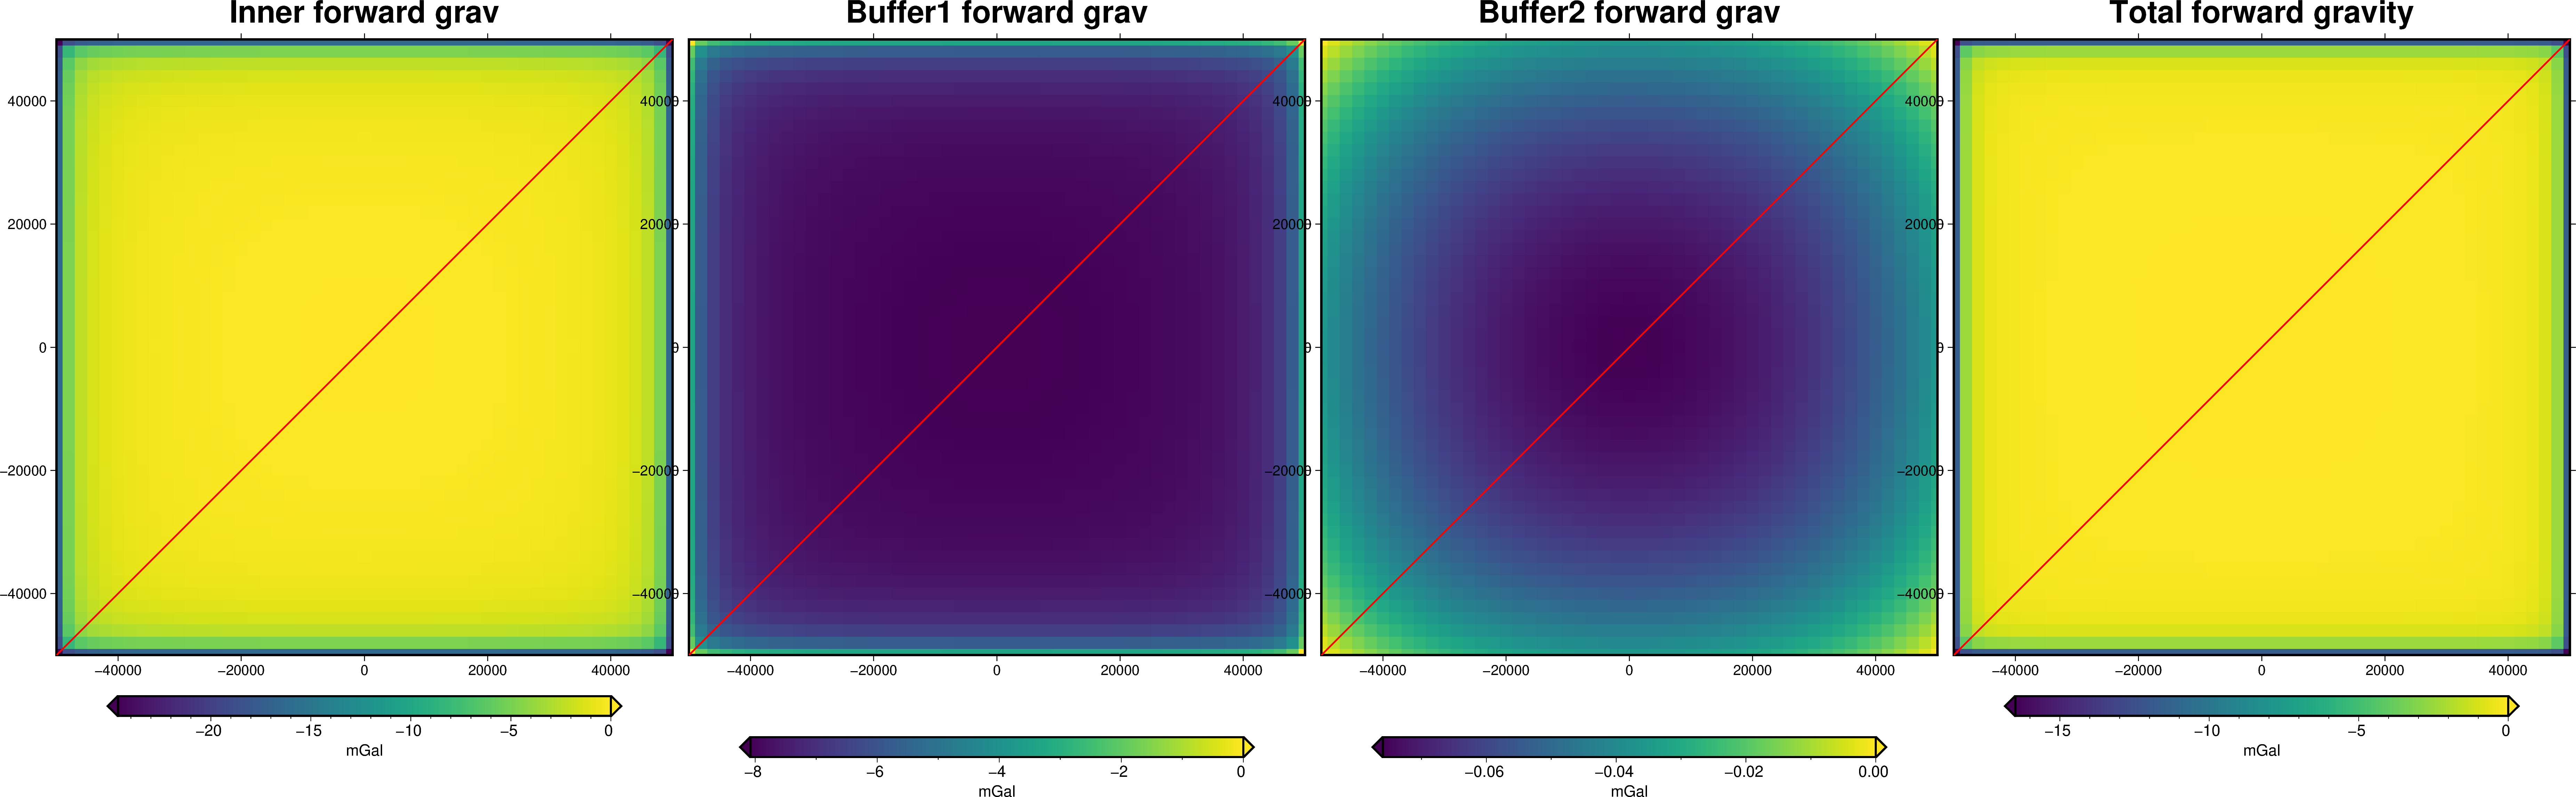

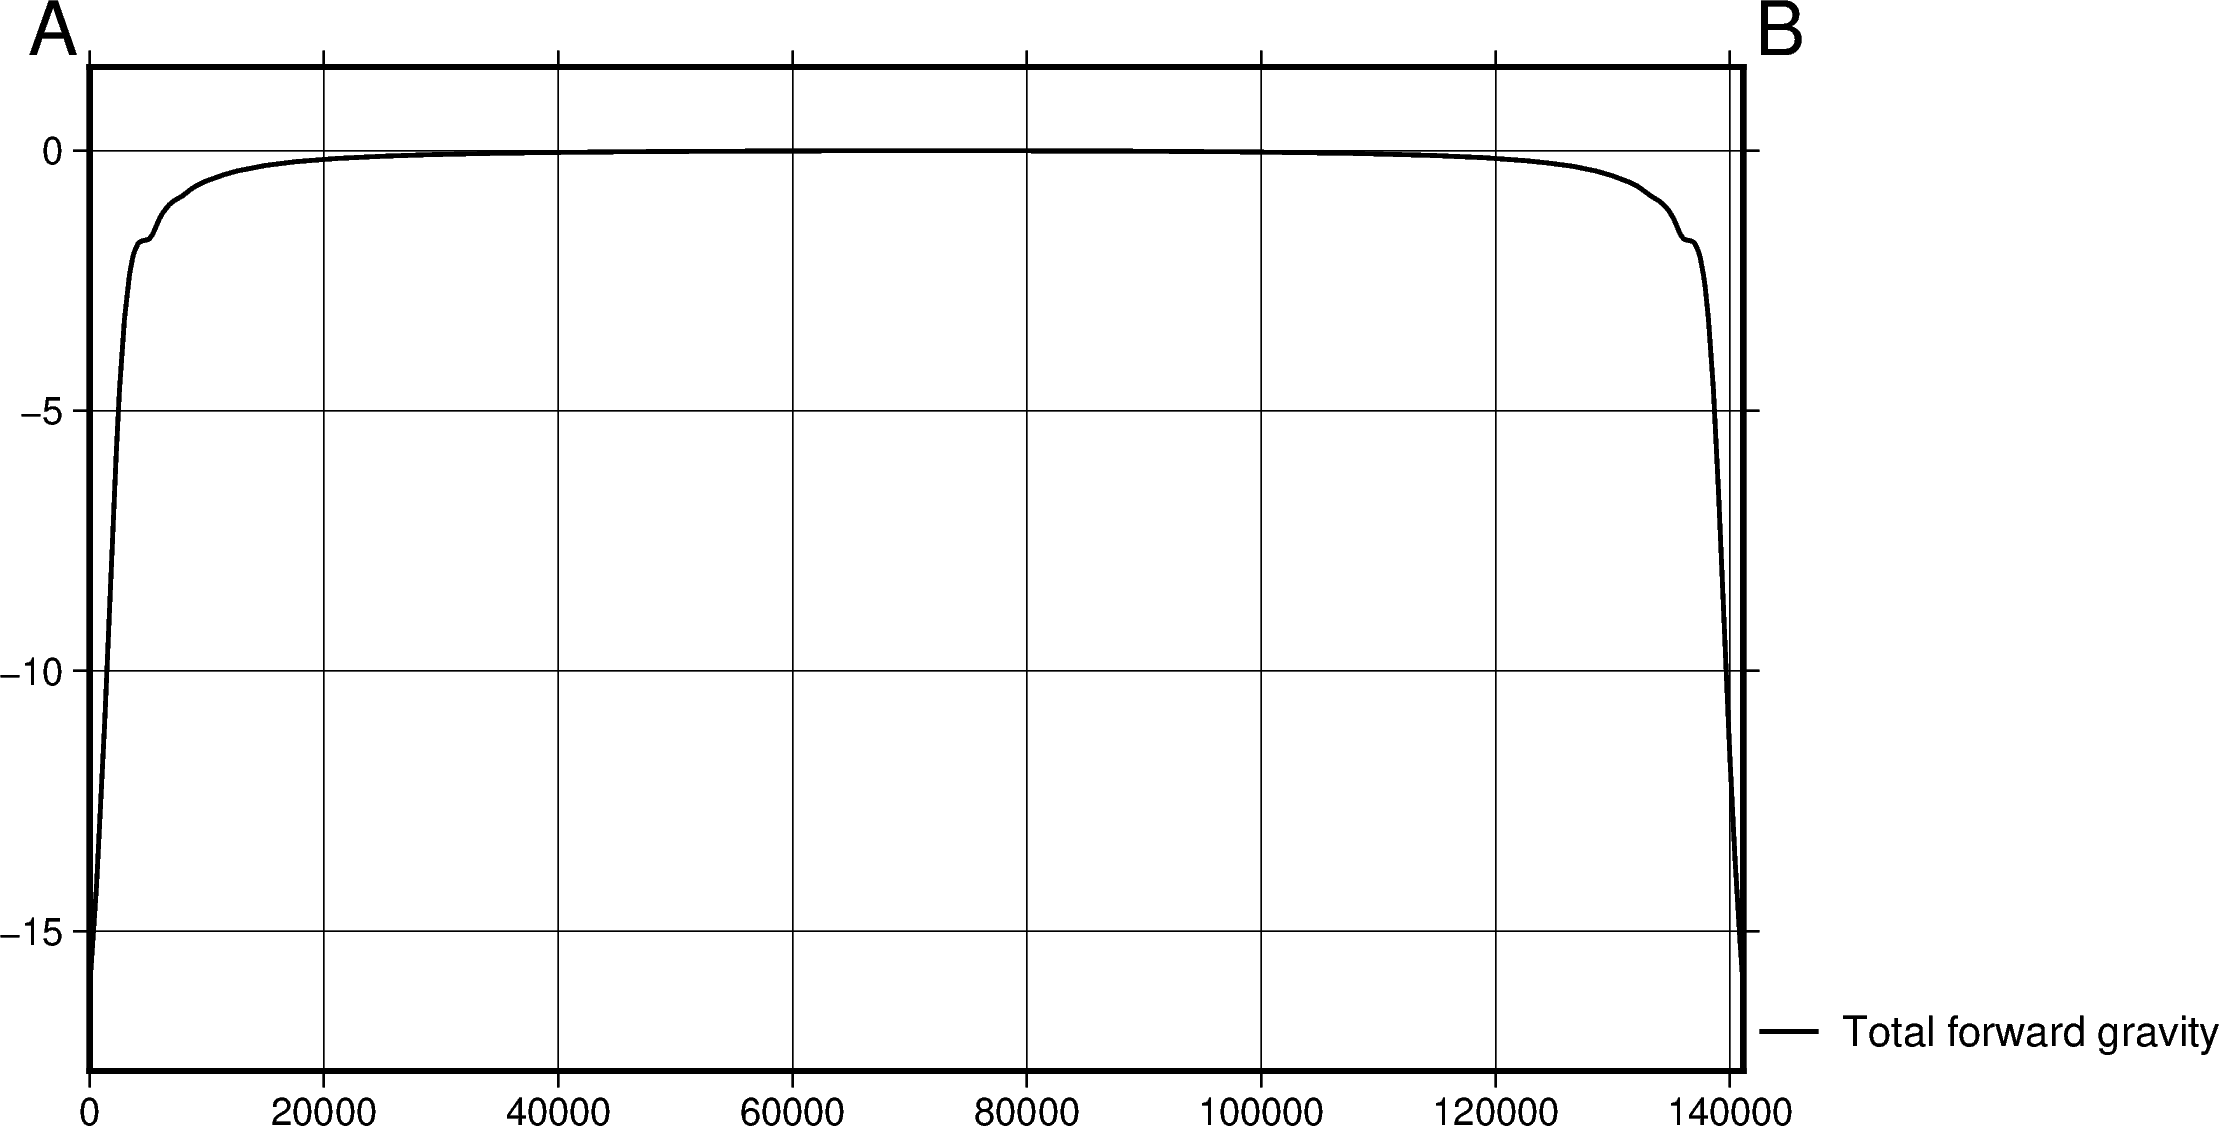

forward calculation took 0.5567214488983154 secs


In [59]:
dual_buffer_forward_grav, dual_buffer_time = forward_grav_of_prismlayer(
    [inner_prisms, buffer1_prisms, buffer2_prisms],
    observation_points,
    plot=True,
    names=["Inner forward grav", "Buffer1 forward grav", "Buffer2 forward grav"],
)
print(f"forward calculation took {dual_buffer_time} secs")

# Compare Methods

<Axes: xlabel='type', ylabel='number_prisms'>

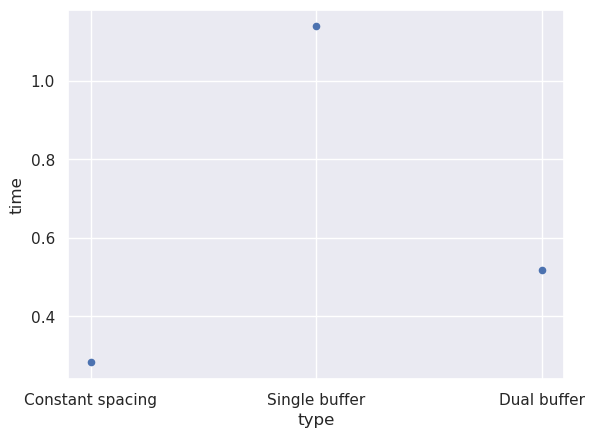

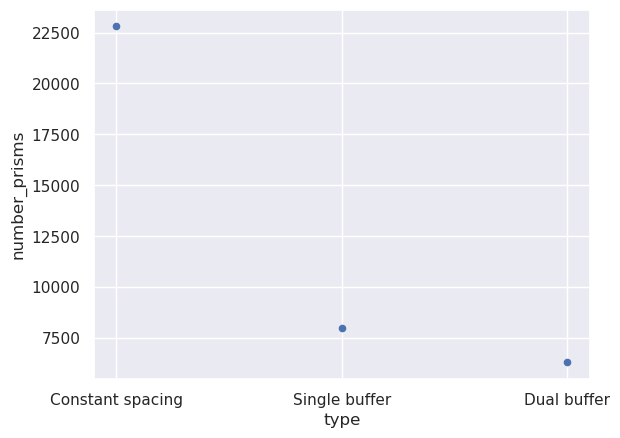

In [33]:
single_buffer_num = len(vd.grid_to_table(inner_prisms)) + len(
    vd.grid_to_table(buffer_prisms)
)
dual_buffer_num = (
    len(vd.grid_to_table(inner_prisms))
    + len(vd.grid_to_table(buffer1_prisms))
    + len(vd.grid_to_table(buffer2_prisms))
)
df = pd.DataFrame(
    (
        ["Constant spacing", constant_time, len(vd.grid_to_table(prisms))],
        ["Single buffer", single_buffer_time, single_buffer_num],
        ["Dual buffer", dual_buffer_time, dual_buffer_num],
    ),
    columns=("type", "time", "number_prisms"),
)
df.plot.scatter("type", "time")
df.plot.scatter("type", "number_prisms")

In [34]:
df.time

0    0.282422
1    1.138610
2    0.517014
Name: time, dtype: float64

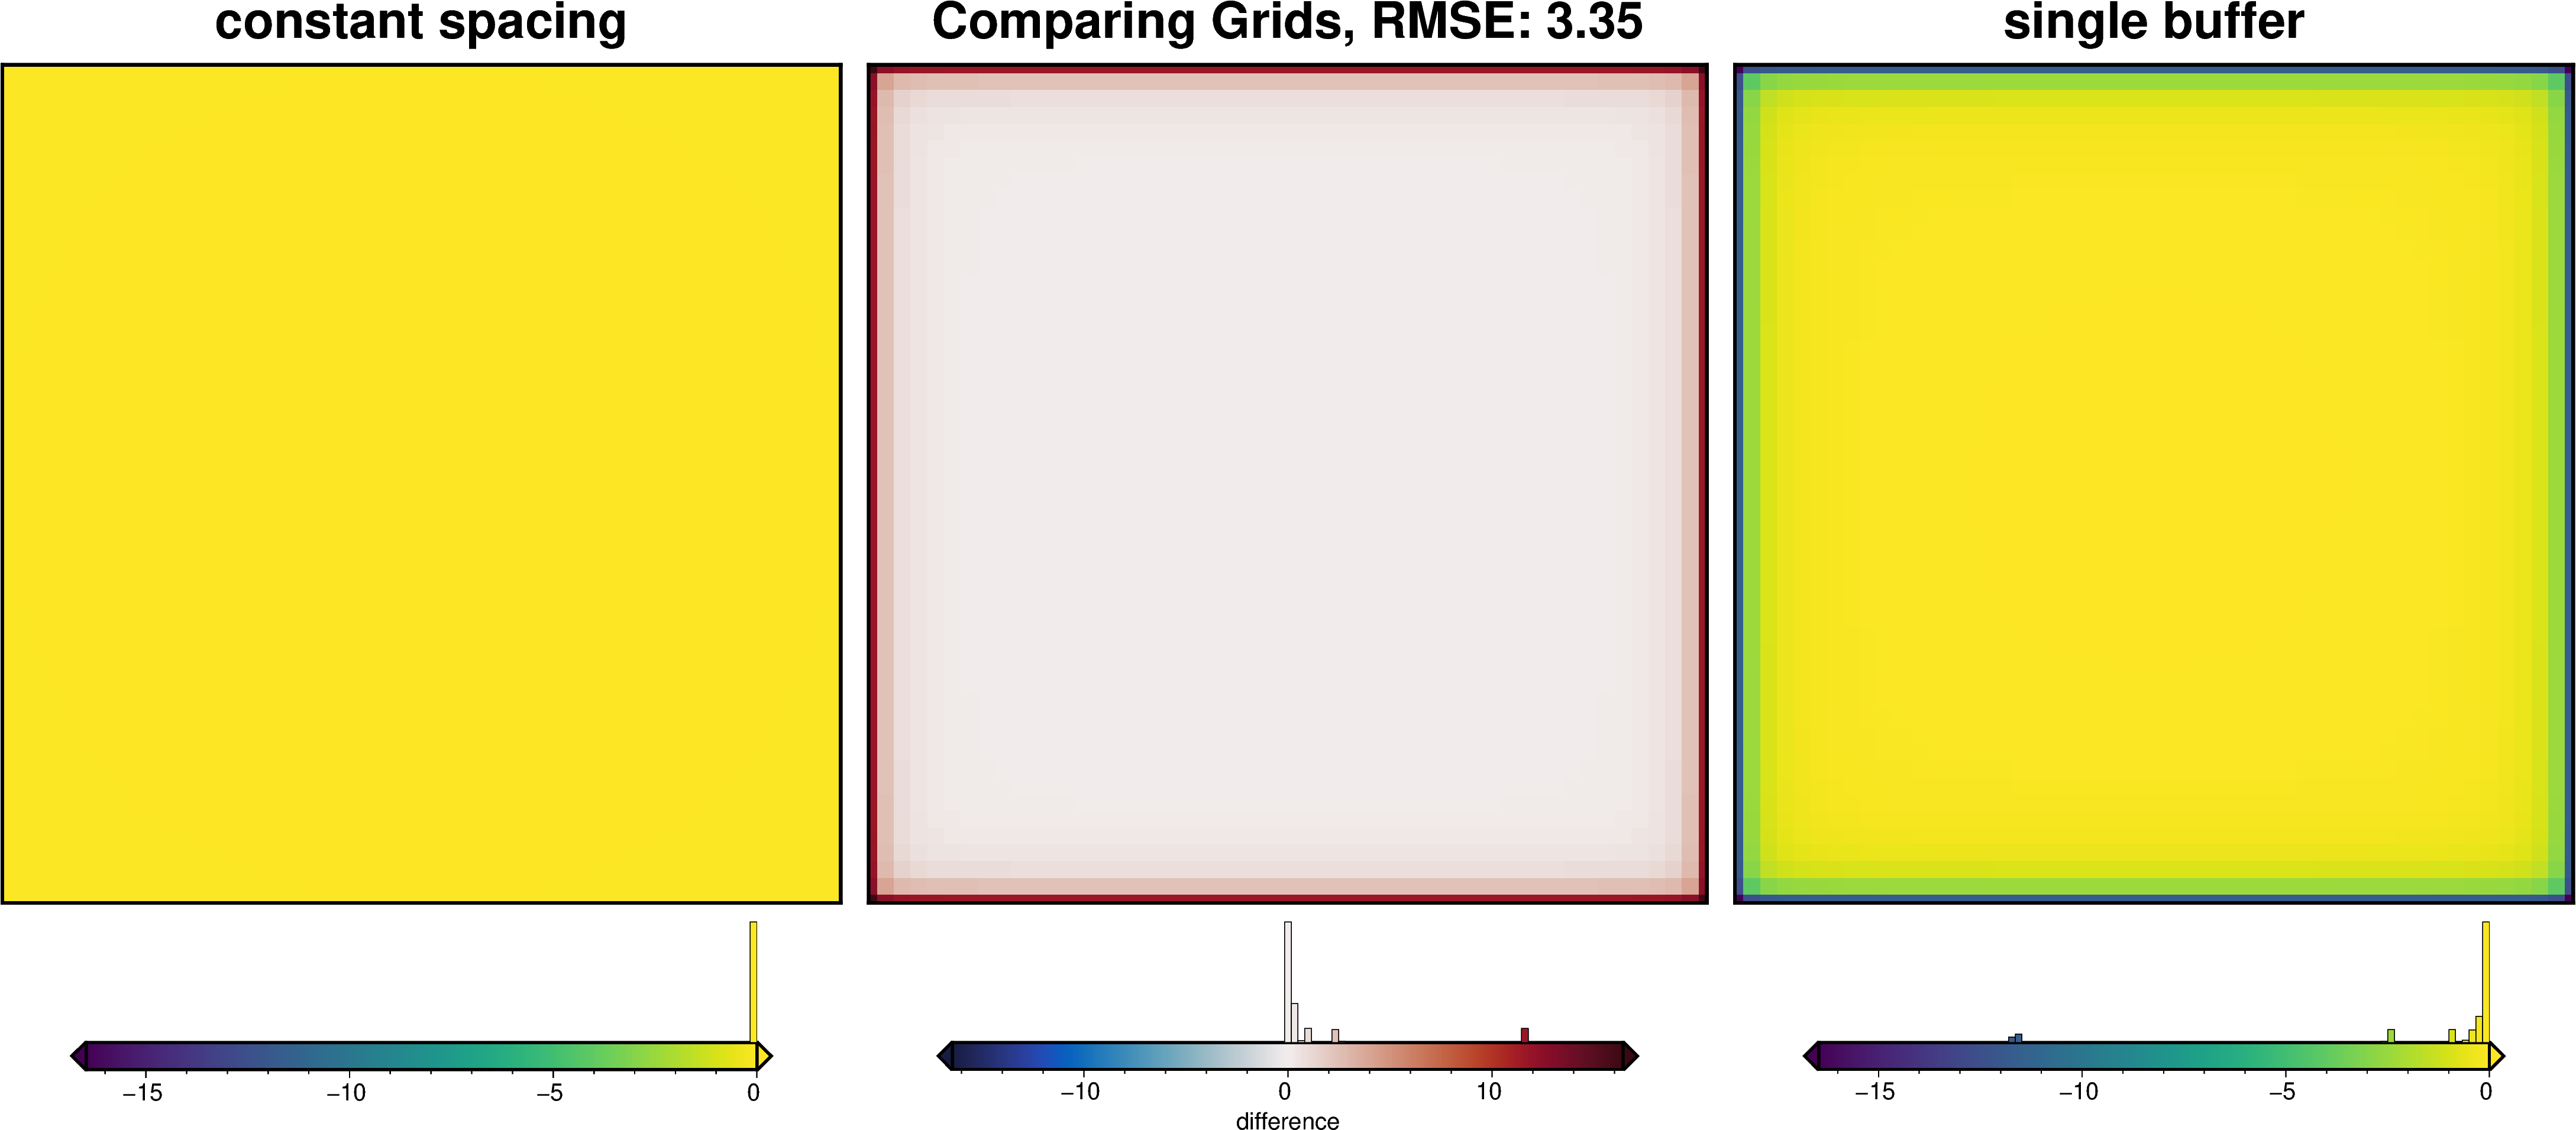

In [35]:
grids = utils.grd_compare(
    constant_forward_grav[0],
    single_buffer_forward_grav[2],
    plot=True,
    inset=False,
    grid1_name="constant spacing",
    grid2_name="single buffer",
    show_region=inner_region,
    hist=True,
)

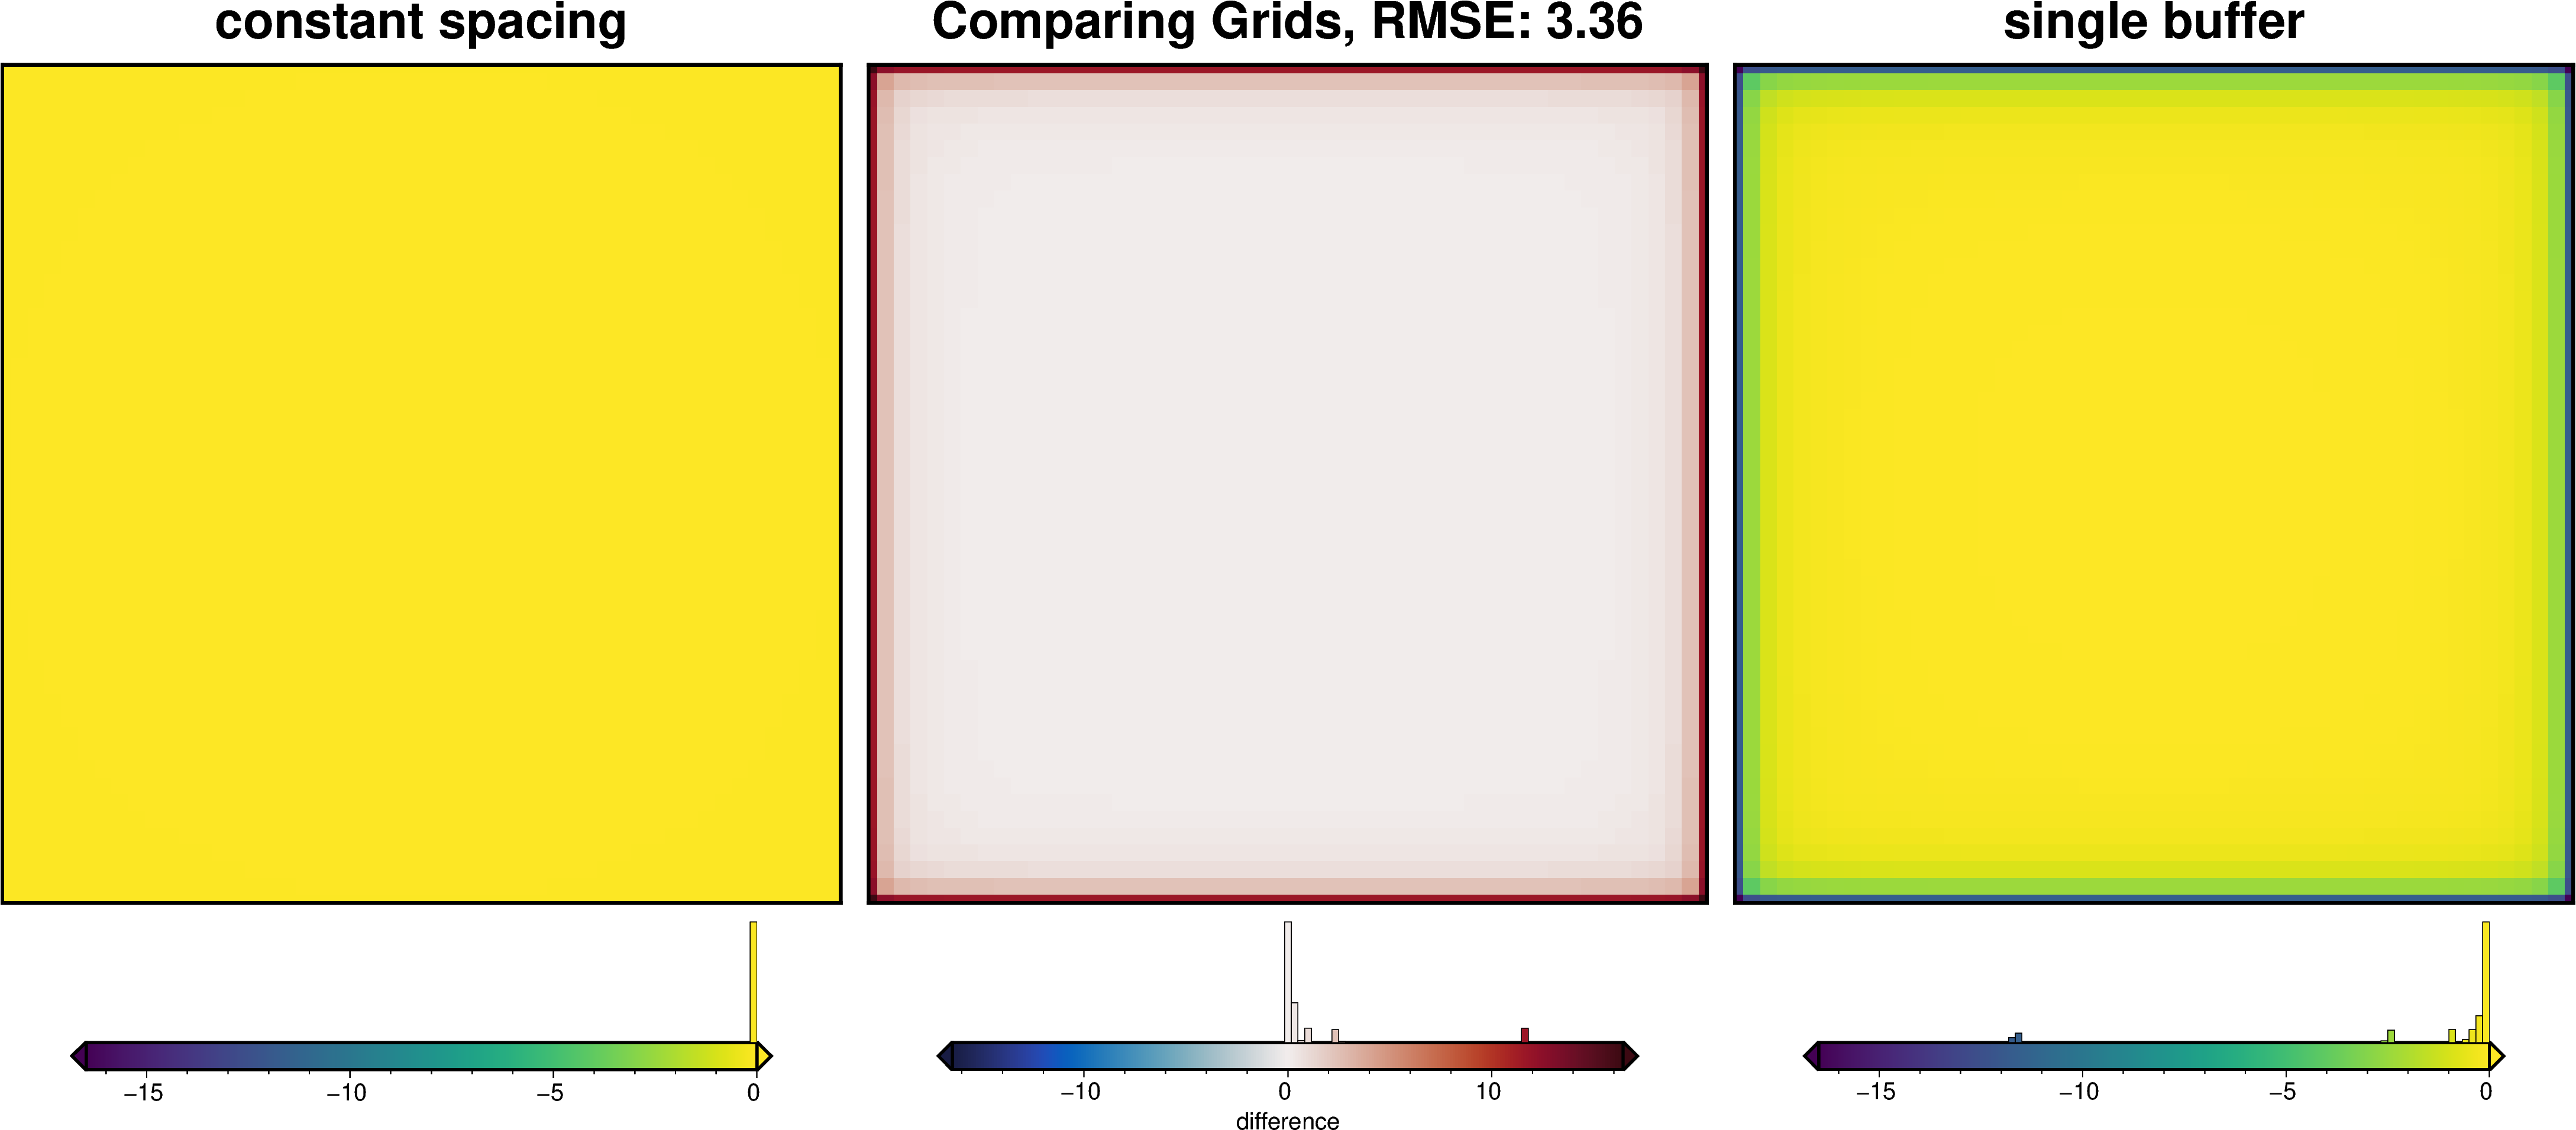

In [36]:
grids = utils.grd_compare(
    constant_forward_grav[0],
    dual_buffer_forward_grav[3],
    plot=True,
    inset=False,
    grid1_name="constant spacing",
    grid2_name="single buffer",
    show_region=inner_region,
    hist=True,
)

In [37]:
frame = (["nSwe", "xaf100000", "yaf100000"],)

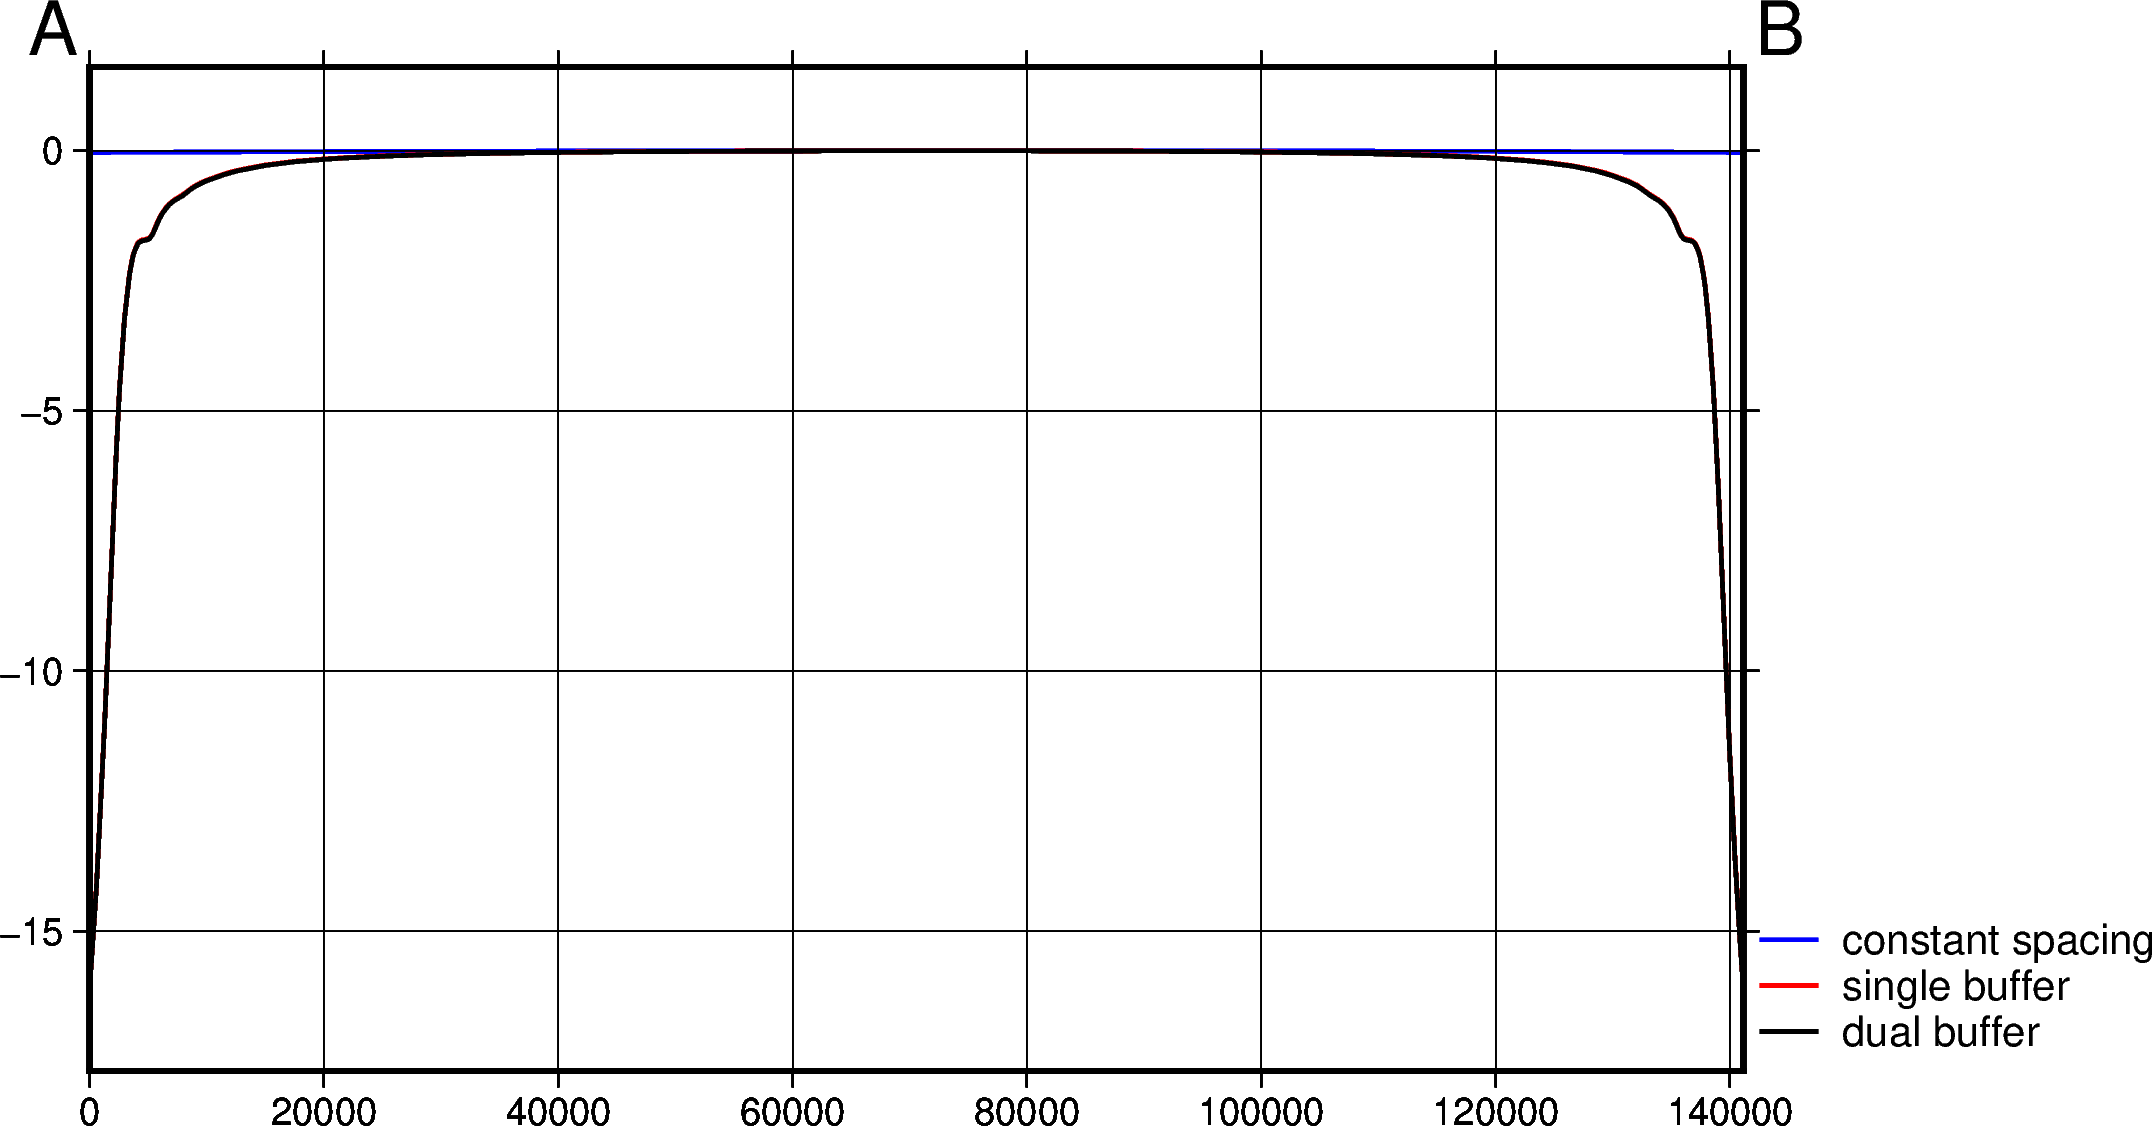

In [40]:
data_dict = profiles.make_data_dict(
    names=["constant spacing", "single buffer", "dual buffer"],
    grids=[
        constant_forward_grav[-1],
        single_buffer_forward_grav[-1],
        dual_buffer_forward_grav[-1],
    ],
    colors=["blue", "red", "black"],
)

fig, _ = profiles.plot_data(
    "points",
    start=(inner_region[0], inner_region[2]),
    stop=(inner_region[1], inner_region[3]),
    data_dict=data_dict,
    share_yaxis=True,
)
fig.show()